## Importing necessary modules

In [1]:
import os
import io
import glob
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from itertools import product

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap

from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

In [2]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
NVIDIA GeForce RTX 3080 Ti


## Random seed

In [3]:
def same_seeds(seed):
    # Python built-in random module
    # random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # qiskit
    algorithm_globals.random_seed = seed

RANDOM_SEED = 0
same_seeds(RANDOM_SEED)

## Directory paths

In [4]:
# Define the directory paths for the results
sub_dirname = '4PCs_QNN_KFold_best_loss'
result_dir = os.path.join("./results", sub_dirname)
results_dir = {
    'figures': os.path.join(result_dir, 'figures'),
    'logs': os.path.join(result_dir, 'logs'),
    'hyperparameters': os.path.join(result_dir, 'hyperparameters'),
    'metrics': os.path.join(result_dir, 'metrics'),
    'checkpoints': os.path.join(result_dir, 'checkpoints'),
}

# Remove the existing directories and create new ones
for key in results_dir.keys():
    if isinstance(results_dir[key], dict):
        for k in results_dir[key].keys():
            if os.path.exists(results_dir[key][k]):
                shutil.rmtree(results_dir[key][k])
            os.makedirs(results_dir[key][k])
    else:
        if os.path.exists(results_dir[key]):
            shutil.rmtree(results_dir[key])
        os.makedirs(results_dir[key])

## Load the 4PCs dataset

In [5]:
# load the dataset
# feature_1, feature_2, feature_3, feature_4, label
train_data_path = './data/X_train__w_4PCs.xlsx'
test_data_path = './data/X_test_w_4PCs.xlsx'
train_data = pd.read_excel(train_data_path)
test_data = pd.read_excel(test_data_path)

# rename the columns
columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'label']
train_data.columns = columns
test_data.columns = columns

# display the dataset information and statistics
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print("-"*50)

print(f"Train data class distribution: \n{train_data['label'].value_counts()}")
print("-"*50)
print(f"Test data class distribution: \n{test_data['label'].value_counts()}")
print("-"*50)

print(f"Train data description: \n{train_data.describe()}")
print(f"Test data description: \n{test_data.describe()}")

Train data shape: (572, 5)
Test data shape: (168, 5)
--------------------------------------------------
Train data class distribution: 
label
1    286
0    286
Name: count, dtype: int64
--------------------------------------------------
Test data class distribution: 
label
0    138
1     30
Name: count, dtype: int64
--------------------------------------------------
Train data description: 
        feature_1   feature_2   feature_3   feature_4       label
count  572.000000  572.000000  572.000000  572.000000  572.000000
mean     0.035352    0.289704    0.313326    0.086765    0.500000
std      0.101878    0.071685    0.110710    0.135735    0.500438
min     -0.710364    0.018118    0.081645   -0.093331    0.000000
25%     -0.004278    0.219892    0.227573   -0.061680    0.000000
50%      0.044331    0.326521    0.304055    0.088931    0.500000
75%      0.106780    0.344385    0.354778    0.193807    1.000000
max      0.187732    0.480324    1.047640    0.492914    1.000000
Test data de

Train data: (572, 5)


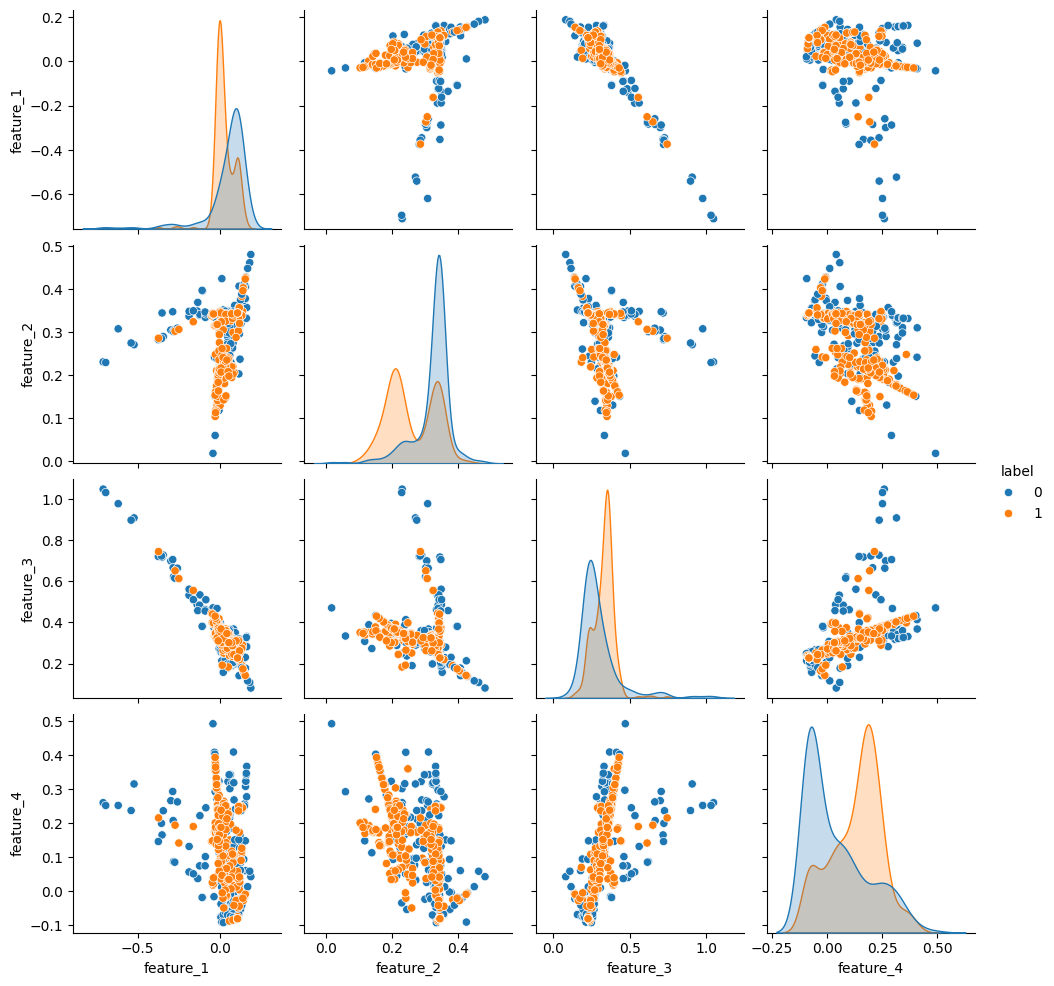

In [6]:
# visualize the train data
print(f'Train data: {train_data.shape}')
sns.pairplot(train_data, hue="label")
plt.show()

Test data: (168, 5)


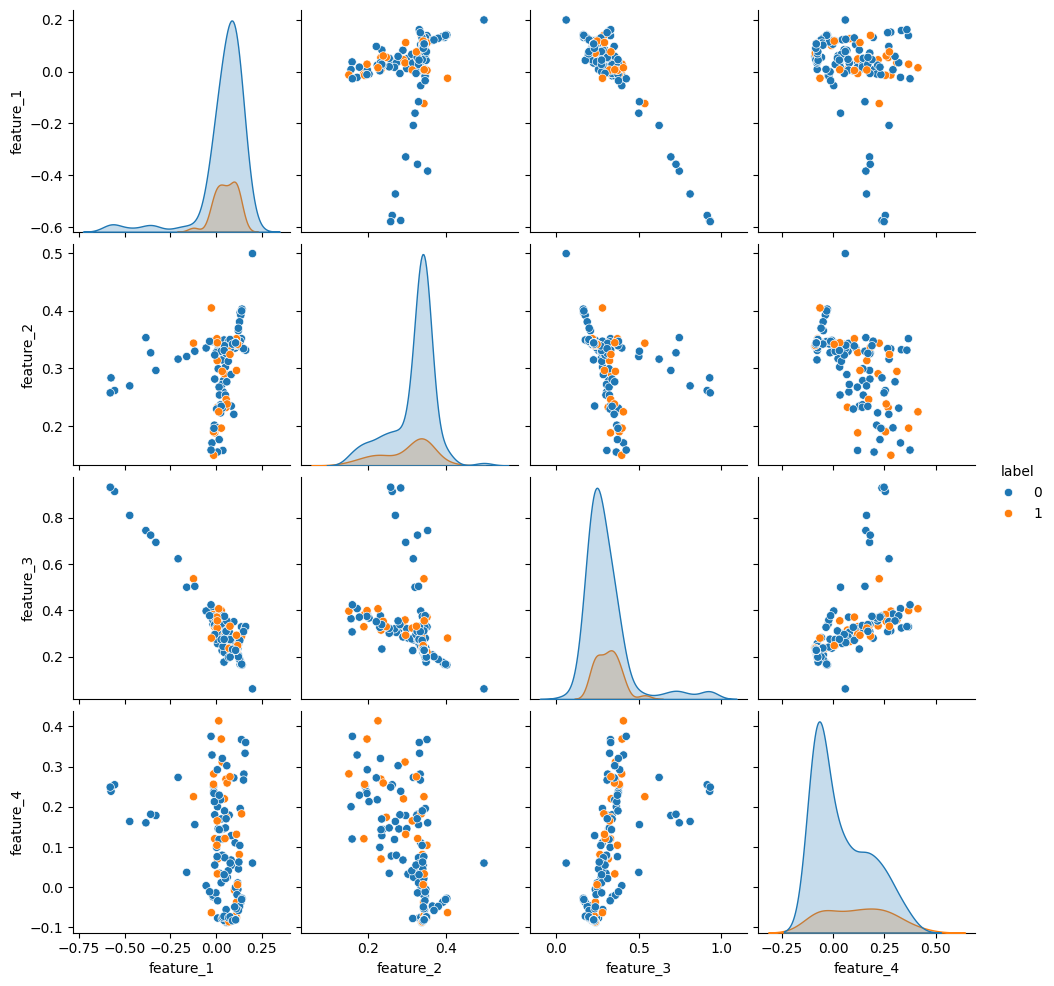

In [7]:
# visualize the test data
print(f'Test data: {test_data.shape}')
sns.pairplot(test_data, hue='label')
plt.show()

## Models

### Example of Parameters

In [8]:
# Example of Parameters
num_qubits_example = 4
feature_map_reps_example = 2
ansatz_reps_example = 2
loss_fn_example = 'cross_entropy'
optimizer_example = COBYLA(maxiter=100)

### Interpret Method

In [9]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2

### VQC Model

In [10]:
from qiskit.primitives import Sampler

def create_VQC_model(num_qubits, feature_map_reps, ansatz_reps, loss_fn, optimizer, callback):
    # Create the feature map and ansatz
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=feature_map_reps)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=ansatz_reps)
    # Create the sampler
    sampler = Sampler()

    # Create the VQC model
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        loss=loss_fn,
        optimizer=optimizer,
        callback=callback,
    )

    return vqc

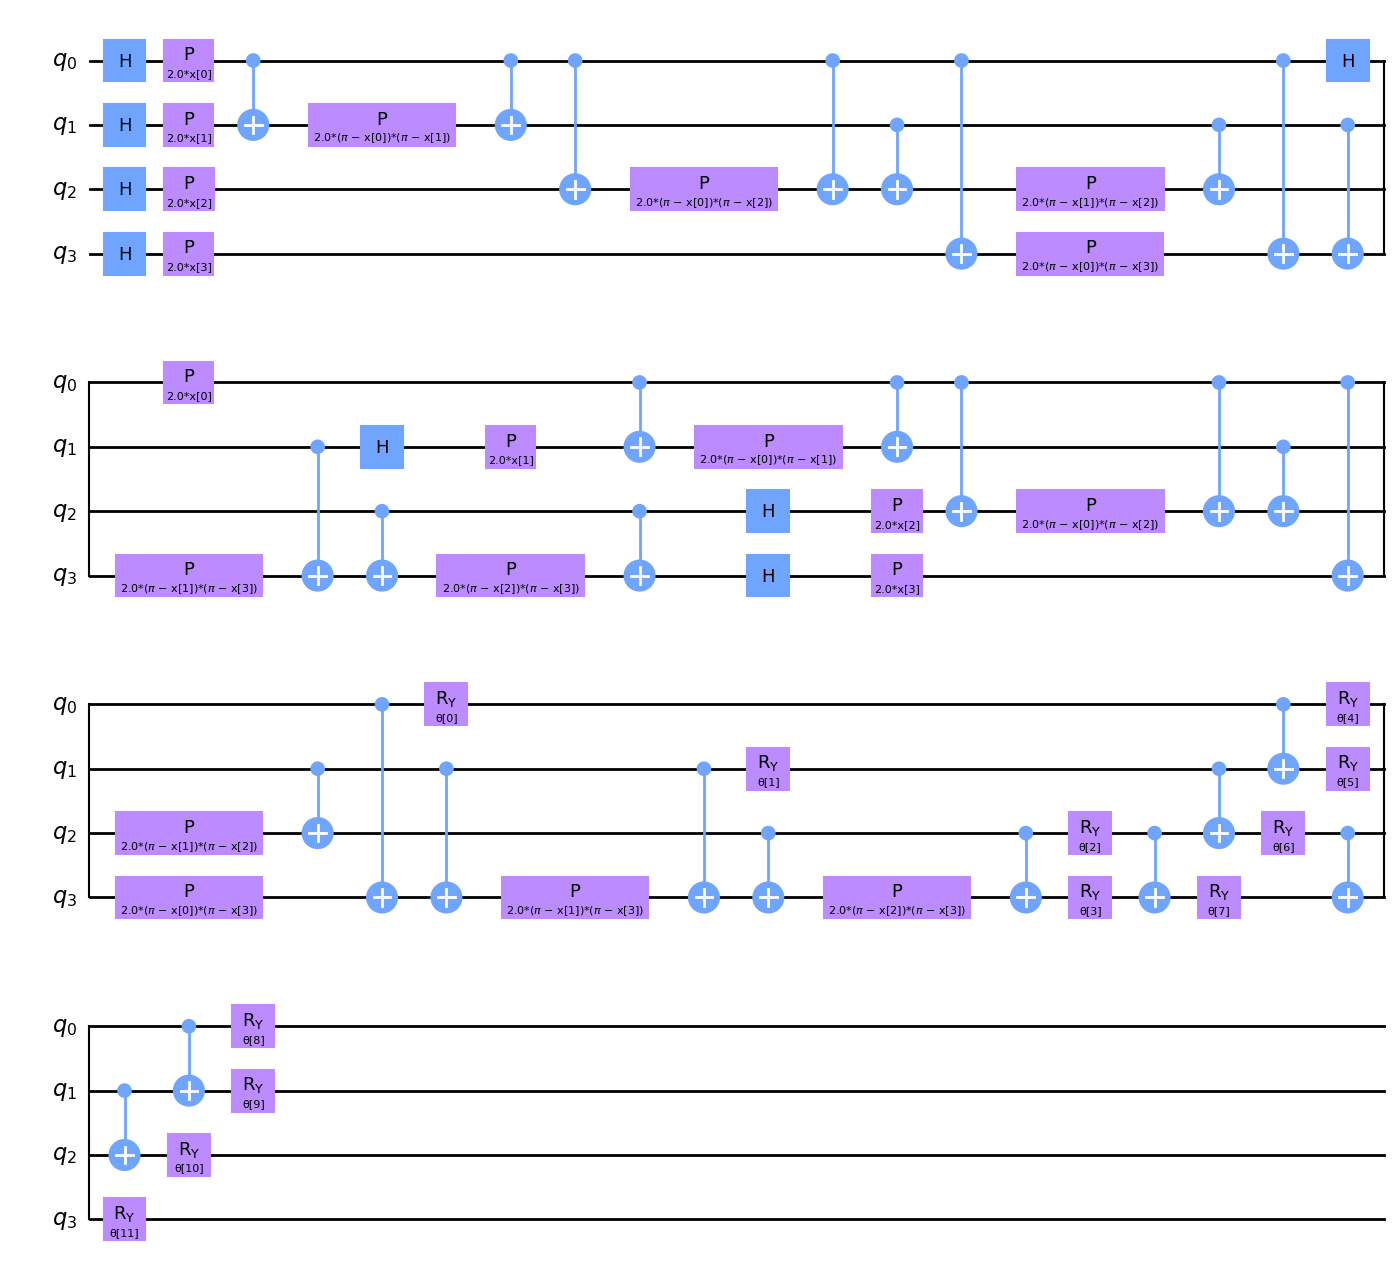

In [11]:
# Example of the VQC model
circuit = create_VQC_model(
    num_qubits=num_qubits_example,
    feature_map_reps=feature_map_reps_example,
    ansatz_reps=ansatz_reps_example,
    loss_fn=loss_fn_example,
    optimizer=optimizer_example,
    callback=None
).circuit
circuit.decompose().draw(output="mpl", style="clifford", fold=20)

### SamplerQNN Model

In [12]:
from qiskit.primitives import Sampler

def create_SamplerQNN_model(num_qubits, feature_map_reps, ansatz_reps, loss_fn, optimizer, callback):
    # Create the feature map and ansatz
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=feature_map_reps)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=ansatz_reps)

    # Create the quantum circuit
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # Create the sampler
    sampler = Sampler()

    # Define the output shape
    output_shape = 2 # parity maps bitstrings to 0 or 1

    # Create the QNN model
    sampler_qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        interpret=parity,
        output_shape=output_shape,
        input_gradients=False
    )

    classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=optimizer,
        callback=callback,
        loss=loss_fn,
        one_hot=True,
    )

    return classifier

C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


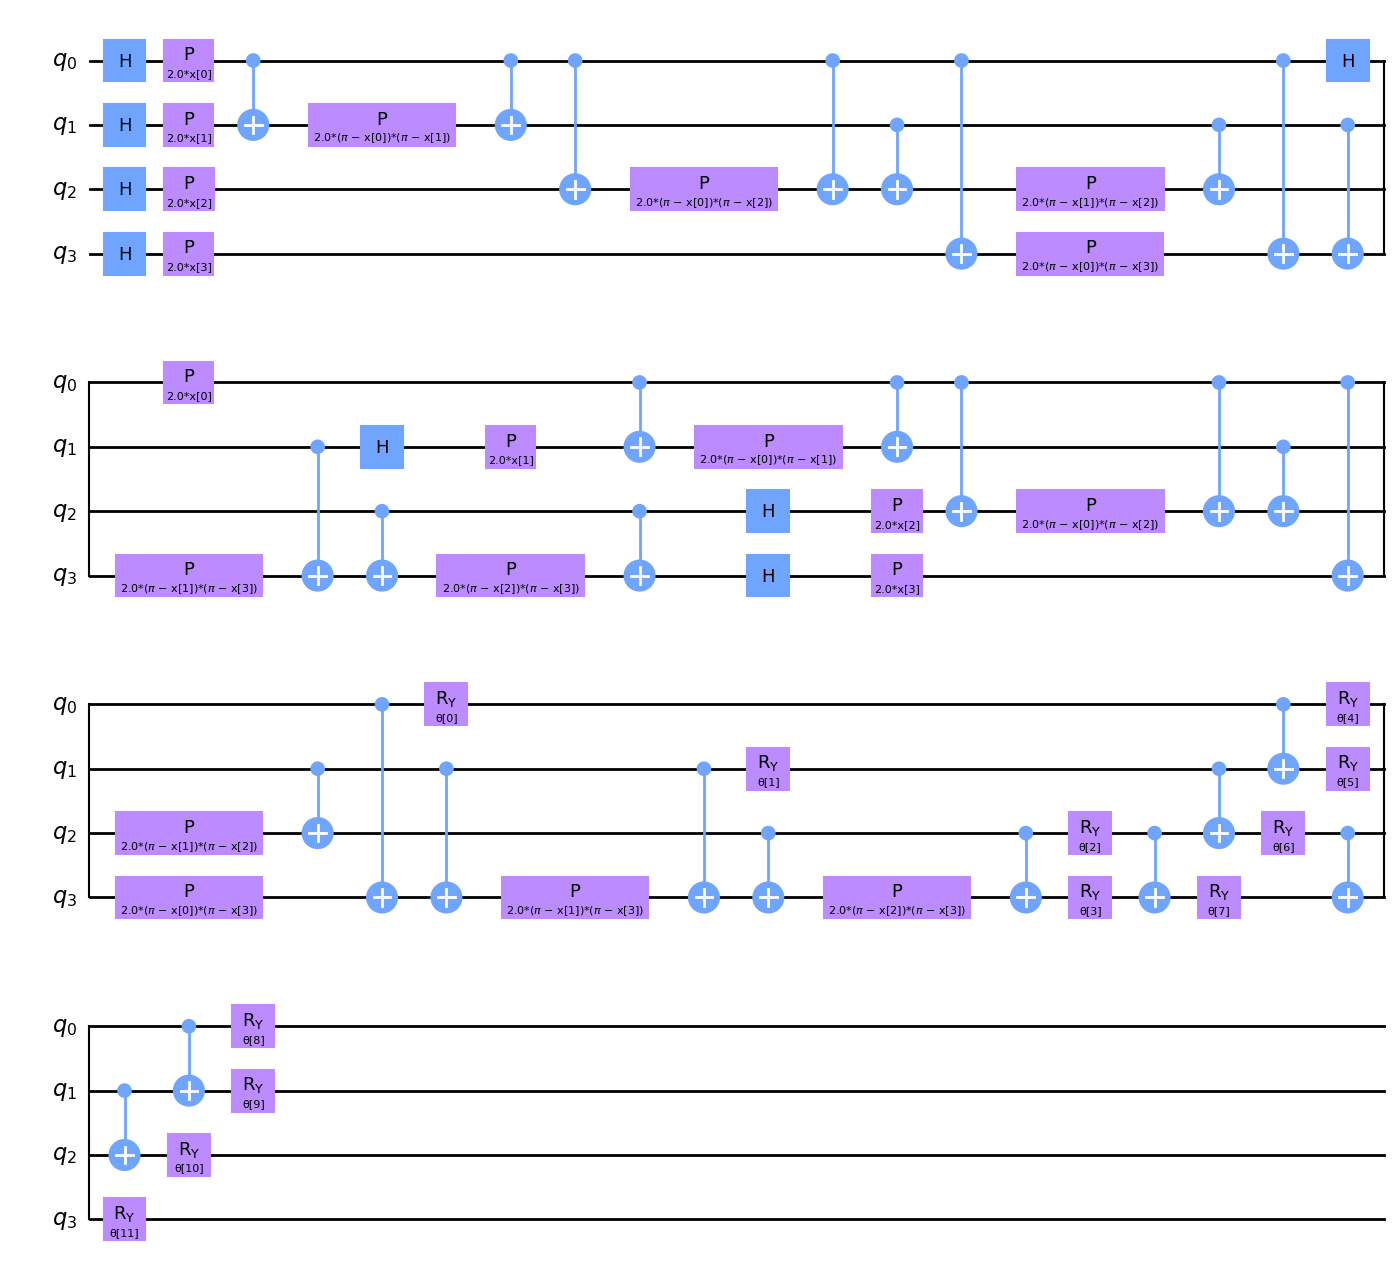

In [13]:
# Example of SampleQNN model
circuit = create_SamplerQNN_model(
    num_qubits=num_qubits_example,
    feature_map_reps=feature_map_reps_example,
    ansatz_reps=ansatz_reps_example,
    loss_fn=loss_fn_example,
    optimizer=optimizer_example,
    callback=None
).neural_network.circuit
circuit.decompose().draw(output="mpl", style="clifford", fold=20)

### SamplerQNN Model with Custom FeatureMap and Ansatz

In [14]:
from qiskit.primitives import Sampler

def custom_feature_map(num_qubits, reps):
    inputs = ParameterVector("input", num_qubits)
    qc = QuantumCircuit(num_qubits)

    for i in range(reps):
        for j in range(num_qubits):
            qc.h(j)
            qc.ry(inputs[j], j)

    return qc

def custom_ansatz(num_qubits, reps):
    weights = ParameterVector("weight", num_qubits * reps)
    qc = QuantumCircuit(num_qubits)

    for i in range(reps):
        for j in range(num_qubits-1):
            qc.cx(j, j + 1)
        qc.cx(num_qubits-1, 0)
        qc.barrier()
        for j in range(num_qubits):
            qc.ry(weights[i*num_qubits + j], j)

    return qc

def create_custom_SamplerQNN_model(num_qubits, feature_map_reps, ansatz_reps, loss_fn, optimizer, callback):
    # Create the feature map and ansatz
    feature_map = custom_feature_map(num_qubits, feature_map_reps)
    ansatz = custom_ansatz(num_qubits, ansatz_reps)

    # Create the quantum circuit
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # Create the sampler
    sampler = Sampler()

    # Define the output shape
    output_shape = 2 # parity maps bitstrings to 0 or 1

    # Create the QNN model
    sampler_qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        interpret=parity,
        output_shape=output_shape,
        input_gradients=False
    )

    # Create the classifier
    classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=optimizer,
        callback=callback,
        loss=loss_fn,
        one_hot=True,
    )

    return classifier

C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\1763415566.py:45: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


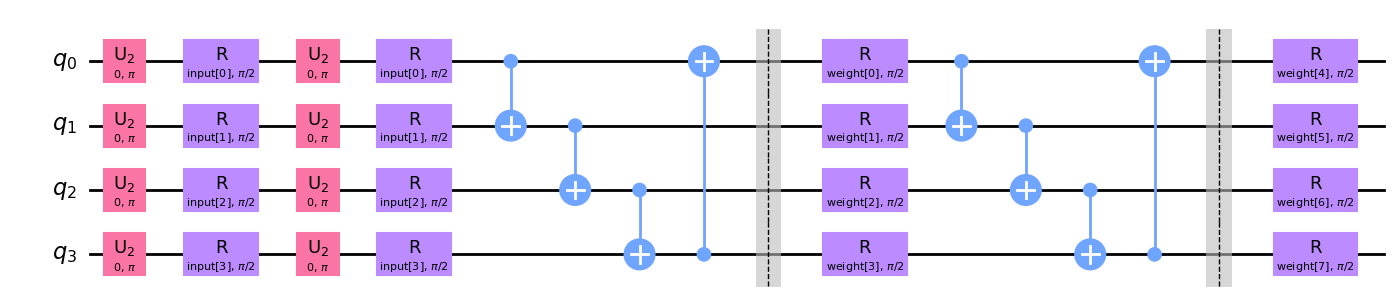

In [15]:
# Example of the custom model
circuit = create_custom_SamplerQNN_model(
    num_qubits=num_qubits_example,
    feature_map_reps=feature_map_reps_example,
    ansatz_reps=ansatz_reps_example,
    loss_fn=loss_fn_example,
    optimizer=optimizer_example,
    callback=None
).neural_network.circuit
circuit.decompose().draw(output="mpl", style="clifford", fold=20)

## Analysis of Validation Metrics

In [16]:
from typing import List

def compute_confusion_matrix_values(confusion):
    """
    Compute the TP, FP, FN, and TN values from the confusion matrix.
    Parameters:
        confusion (np.ndarray): Confusion matrix of shape (n_classes, n_classes).
    Returns:
        tuple: Tuple containing TP, FP, FN, and TN values.
    """
    if confusion.shape == (2, 2):
        """
        [
            [TN, FP]
            [FN, TP]
        ]
        """
        TN, FP, FN, TP = confusion.ravel()
    else:
        # True Positive: The number of samples that the model correctly predicts as class i
        TP = np.diag(confusion)
        # False Positive: The number of samples that the model incorrectly predicts as class i
        FP = confusion.sum(axis=0) - TP
        # False Negative: The number of samples that the model incorrectly predicts as not class i
        FN = confusion.sum(axis=1) - TP
        # True Negative: The number of samples that the model correctly predicts as not class i
        TN = confusion.sum() - (TP + FP + FN)
    return TP, FP, FN, TN

def calculate_metrics(confusion, average=None, weighted=None):
    """
    Calculate various classification metrics based on the provided confusion matrix.
    Parameters:
        confusion (np.ndarray): Confusion matrix of shape (n_classes, n_classes).
        average (str, optional): Type of averaging to be performed on the data.
                                Options are 'micro', 'macro', 'weighted', or None. Default is None.
        weighted (list or np.ndarray, optional): Weights for each class if average is 'weighted'.
                                                Must be provided if average is 'weighted'.
    Returns:
        dict: Dictionary containing the calculated metrics.
    """
    # Check the input arguments
    if isinstance(confusion, List):
        confusion = np.array(confusion) # Convert the list to a numpy array
    if not isinstance(confusion, np.ndarray):
        raise TypeError("The confusion matrix must be a numpy array.")
    if len(confusion.shape) != 2 or confusion.shape[0] != confusion.shape[1]:
        raise ValueError("The confusion matrix must be a square matrix.")
    if average not in [None, 'macro', 'micro', 'weighted']:
        raise ValueError("The average must be one of 'micro', 'macro', 'weighted', or None.")
    if average == 'weighted' and weighted is None:
        raise ValueError("The weights must be provided if average is 'weighted'.")
    if weighted is not None and len(confusion) != len(weighted):
        raise ValueError("The number of classes and the length of the weights must be the same.")

    # Compute the TP, FP, FN, and TN values
    TP, FP, FN, TN = compute_confusion_matrix_values(confusion)

    # If the average is 'micro', sum the values
    if average == 'micro':
        TP, FP, FN, TN = map(np.sum, [TP, FP, FN, TN])

    def safe_divide(numerator, denominator):
        """Safely divide two numbers, returning 0 if the denominator is 0."""
        return np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator!=0)

    # Initialize the metrics dictionary
    metrics = {}

    # Accuracy (ACC)
    accuracy = safe_divide(TP + TN, TP + TN + FP + FN)
    # Precision or Positive Predictive Value (PPV)
    precision = safe_divide(TP, TP + FP)
    # Recall or Sensitivity or True Positive Rate (TPR)
    recall = safe_divide(TP, TP + FN)
    # F1 Score
    f1 = safe_divide(2 * (precision * recall), precision + recall)
    # Matthews Correlation Coefficient (MCC)
    mcc = safe_divide((TP * TN - FP * FN), np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))
    # Negative Predictive Value (NPV)
    npv = safe_divide(TN, TN + FN)
    # True Negative Rate (TNR) or Specificity (SPC)
    tnr = safe_divide(TN, TN + FP)
    # False Positive Rate (FPR)
    fpr = safe_divide(FP, TN + FP)
    # False Discovery Rate (FDR)
    fdr = safe_divide(FP, TP + FP)
    # False Negative Rate (FNR)
    fnr = safe_divide(FN, TP + FN)

    # Create a dictionary of all metrics
    metrics = {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'TPR': recall,
        'SPC': tnr,
        'PPV': precision,
        'F1': f1,
        'ACC': accuracy,
        'NPV': npv,
        'FPR': fpr,
        'FDR': fdr,
        'FNR': fnr,
        'MCC': mcc
    }

    if average == 'macro':
        for metric, values in metrics.items():
            metrics[metric] = np.mean(values)
    elif average == 'weighted':
        for metric, values in metrics.items():
            metrics[metric] = np.average(values, weights=weighted)

    return metrics

## Hyperparameters

In [17]:
# Define the hyperparameters
target_names = ['Class 0', 'Class 1']
k_folds = 5 # K-fold cross-validation
optimizer_fn = COBYLA
loss_fn = 'cross_entropy'
average = 'macro'

In [18]:
# Define the search space for the hyperparameters
models = ['SamplerQNN']
epochs = [50, 100, 200]
feature_map_reps_list = [2, 3]
ansatz_reps_list = [2, 3]

In [19]:
# Function to create the model based on the parameters
def get_create_model_function(model_name):
    if model_name == 'VQC':
        return create_VQC_model
    elif model_name == 'SamplerQNN':
        return create_SamplerQNN_model
    elif model_name == 'CustomSamplerQNN':
        return create_custom_SamplerQNN_model
    else:
        raise ValueError(f"Invalid model name: {model_name}")

In [20]:
# Create the parameter combinations
param_combinations = list(product(models, epochs, feature_map_reps_list, ansatz_reps_list))

print(f"Number of parameter combinations: {len(param_combinations)}")
for i, params in enumerate(param_combinations):
    model_name, epochs, feature_map_reps, ansatz_reps = params
    print(f"Parameter combination {i+1}:")
    print(f"\tModel: {model_name}")
    print(f"\tEpochs: {epochs}")
    print(f"\tFeature map reps: {feature_map_reps}")
    print(f"\tAnsatz reps: {ansatz_reps}")

Number of parameter combinations: 12
Parameter combination 1:
	Model: SamplerQNN
	Epochs: 50
	Feature map reps: 2
	Ansatz reps: 2
Parameter combination 2:
	Model: SamplerQNN
	Epochs: 50
	Feature map reps: 2
	Ansatz reps: 3
Parameter combination 3:
	Model: SamplerQNN
	Epochs: 50
	Feature map reps: 3
	Ansatz reps: 2
Parameter combination 4:
	Model: SamplerQNN
	Epochs: 50
	Feature map reps: 3
	Ansatz reps: 3
Parameter combination 5:
	Model: SamplerQNN
	Epochs: 100
	Feature map reps: 2
	Ansatz reps: 2
Parameter combination 6:
	Model: SamplerQNN
	Epochs: 100
	Feature map reps: 2
	Ansatz reps: 3
Parameter combination 7:
	Model: SamplerQNN
	Epochs: 100
	Feature map reps: 3
	Ansatz reps: 2
Parameter combination 8:
	Model: SamplerQNN
	Epochs: 100
	Feature map reps: 3
	Ansatz reps: 3
Parameter combination 9:
	Model: SamplerQNN
	Epochs: 200
	Feature map reps: 2
	Ansatz reps: 2
Parameter combination 10:
	Model: SamplerQNN
	Epochs: 200
	Feature map reps: 2
	Ansatz reps: 3
Parameter combination 11:


## Stratified K-Fold Cross Validation
Find the best parameter combinations

In [21]:
# Split the data into features and labels
x_train = train_data.iloc[:, :-1].values
y_train = train_data['label'].values
x_test = test_data.iloc[:, :-1].values
y_test = test_data['label'].values

In [22]:
objective_func_vals = [] # To store the objective function values
def callback_recorder(weights, obj_func_eval):
        objective_func_vals.append(obj_func_eval)

Parameter combination 1/12
Model: SamplerQNN, Epochs: 50, Feature map reps: 2, Ansatz reps: 2


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


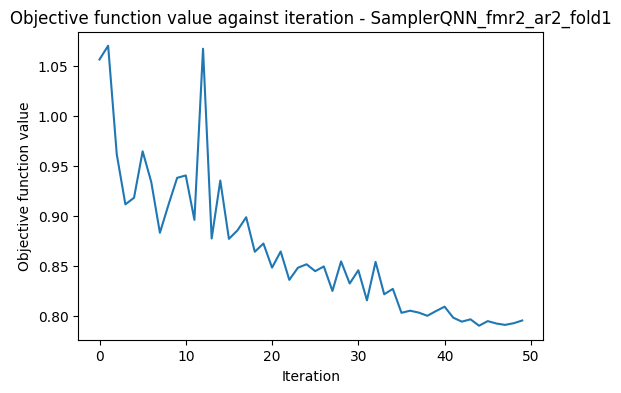

Final loss: 0.7954419392174336
Validation score: 0.7391304347826086


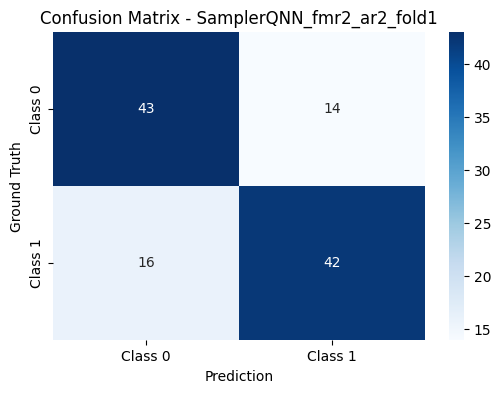

Classification report:
              precision    recall  f1-score   support

     Class 0       0.73      0.75      0.74        57
     Class 1       0.75      0.72      0.74        58

    accuracy                           0.74       115
   macro avg       0.74      0.74      0.74       115
weighted avg       0.74      0.74      0.74       115

Averaging method: macro
Metrics:
	TP: 42.0
	FP: 14.0
	FN: 16.0
	TN: 43.0
	TPR: 0.7241
	SPC: 0.7544
	PPV: 0.75
	F1: 0.7368
	ACC: 0.7391
	NPV: 0.7288
	FPR: 0.2456
	FDR: 0.25
	FNR: 0.2759
	MCC: 0.4787
Fold time: 169 seconds
Fold 2:


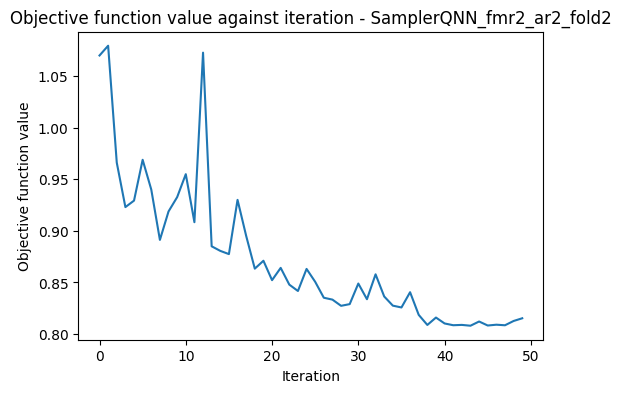

Final loss: 0.8152100242244662
Validation score: 0.7478260869565218


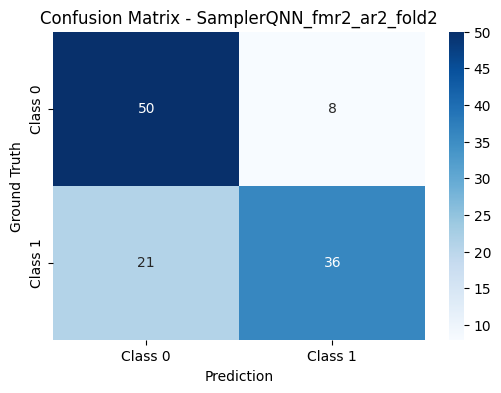

Classification report:
              precision    recall  f1-score   support

     Class 0       0.70      0.86      0.78        58
     Class 1       0.82      0.63      0.71        57

    accuracy                           0.75       115
   macro avg       0.76      0.75      0.74       115
weighted avg       0.76      0.75      0.74       115

Averaging method: macro
Metrics:
	TP: 36.0
	FP: 8.0
	FN: 21.0
	TN: 50.0
	TPR: 0.6316
	SPC: 0.8621
	PPV: 0.8182
	F1: 0.7129
	ACC: 0.7478
	NPV: 0.7042
	FPR: 0.1379
	FDR: 0.1818
	FNR: 0.3684
	MCC: 0.5078
Fold time: 187 seconds
Fold 3:


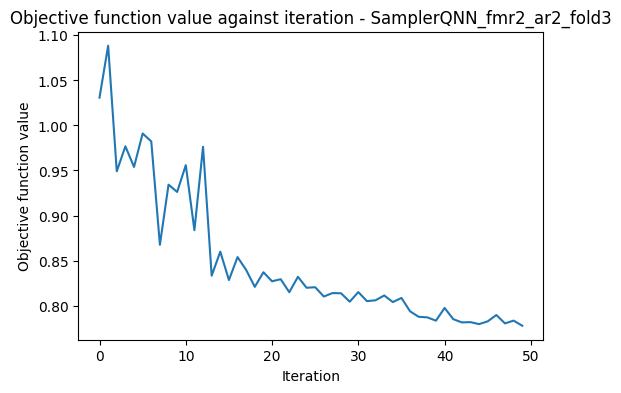

Final loss: 0.7776695668652539
Validation score: 0.7017543859649122


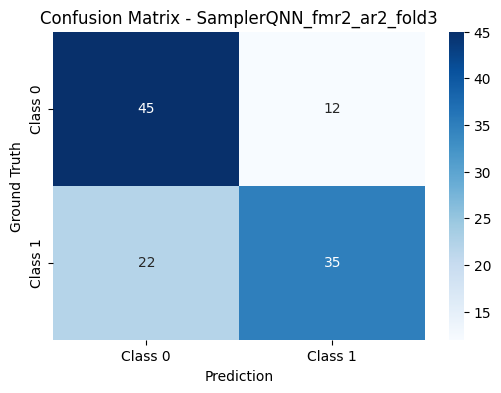

Classification report:
              precision    recall  f1-score   support

     Class 0       0.67      0.79      0.73        57
     Class 1       0.74      0.61      0.67        57

    accuracy                           0.70       114
   macro avg       0.71      0.70      0.70       114
weighted avg       0.71      0.70      0.70       114

Averaging method: macro
Metrics:
	TP: 35.0
	FP: 12.0
	FN: 22.0
	TN: 45.0
	TPR: 0.614
	SPC: 0.7895
	PPV: 0.7447
	F1: 0.6731
	ACC: 0.7018
	NPV: 0.6716
	FPR: 0.2105
	FDR: 0.2553
	FNR: 0.386
	MCC: 0.4099
Fold time: 188 seconds
Fold 4:


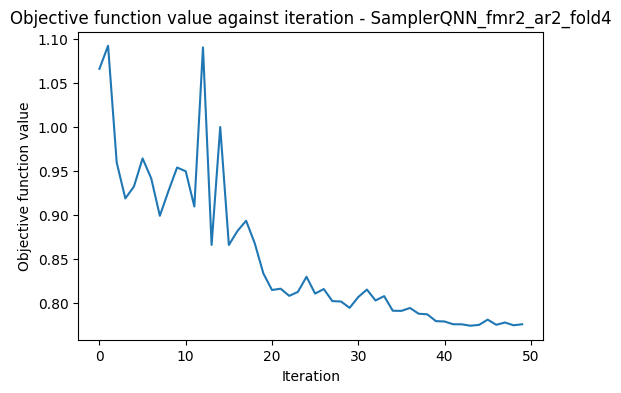

Final loss: 0.7762802375771948
Validation score: 0.7017543859649122


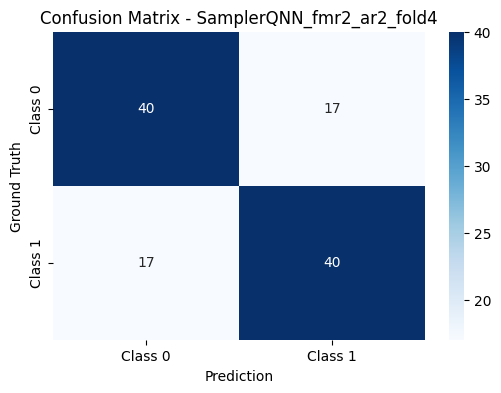

Classification report:
              precision    recall  f1-score   support

     Class 0       0.70      0.70      0.70        57
     Class 1       0.70      0.70      0.70        57

    accuracy                           0.70       114
   macro avg       0.70      0.70      0.70       114
weighted avg       0.70      0.70      0.70       114

Averaging method: macro
Metrics:
	TP: 40.0
	FP: 17.0
	FN: 17.0
	TN: 40.0
	TPR: 0.7018
	SPC: 0.7018
	PPV: 0.7018
	F1: 0.7018
	ACC: 0.7018
	NPV: 0.7018
	FPR: 0.2982
	FDR: 0.2982
	FNR: 0.2982
	MCC: 0.4035
Fold time: 188 seconds
Fold 5:


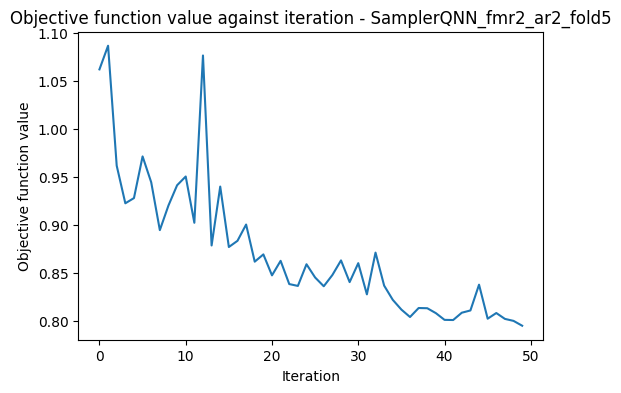

Final loss: 0.7953599849398213
Validation score: 0.7280701754385965


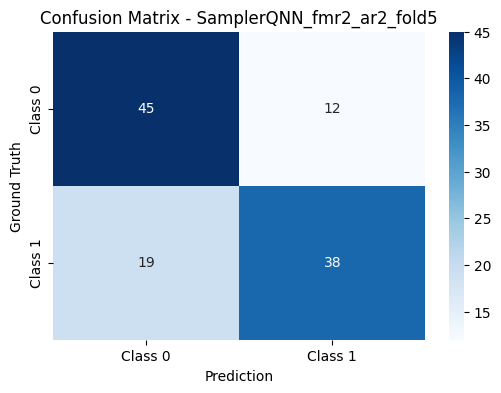

Classification report:
              precision    recall  f1-score   support

     Class 0       0.70      0.79      0.74        57
     Class 1       0.76      0.67      0.71        57

    accuracy                           0.73       114
   macro avg       0.73      0.73      0.73       114
weighted avg       0.73      0.73      0.73       114

Averaging method: macro
Metrics:
	TP: 38.0
	FP: 12.0
	FN: 19.0
	TN: 45.0
	TPR: 0.6667
	SPC: 0.7895
	PPV: 0.76
	F1: 0.7103
	ACC: 0.7281
	NPV: 0.7031
	FPR: 0.2105
	FDR: 0.24
	FNR: 0.3333
	MCC: 0.4596
Fold time: 162 seconds
Mean validation loss: 0.7919923505648339
Parameter combination 2/12
Model: SamplerQNN, Epochs: 50, Feature map reps: 2, Ansatz reps: 3


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


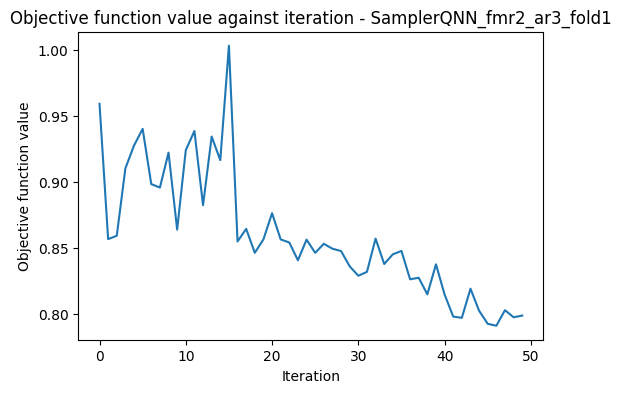

Final loss: 0.7987581055756464
Validation score: 0.7478260869565218


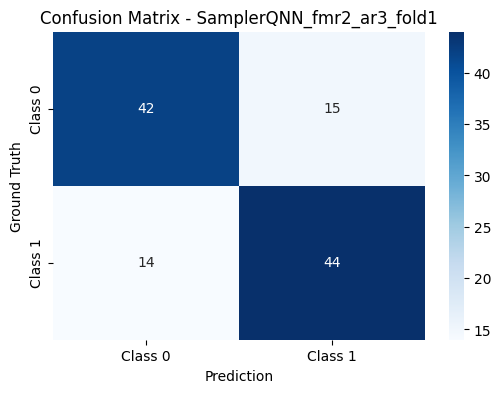

Classification report:
              precision    recall  f1-score   support

     Class 0       0.75      0.74      0.74        57
     Class 1       0.75      0.76      0.75        58

    accuracy                           0.75       115
   macro avg       0.75      0.75      0.75       115
weighted avg       0.75      0.75      0.75       115

Averaging method: macro
Metrics:
	TP: 44.0
	FP: 15.0
	FN: 14.0
	TN: 42.0
	TPR: 0.7586
	SPC: 0.7368
	PPV: 0.7458
	F1: 0.7521
	ACC: 0.7478
	NPV: 0.75
	FPR: 0.2632
	FDR: 0.2542
	FNR: 0.2414
	MCC: 0.4956
Fold time: 152 seconds
Fold 2:


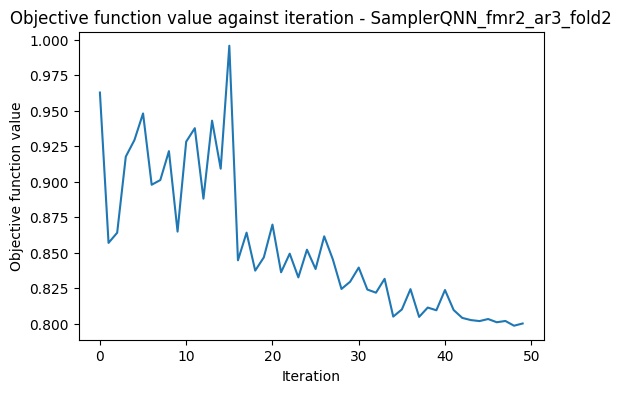

Final loss: 0.8001158947121336
Validation score: 0.7391304347826086


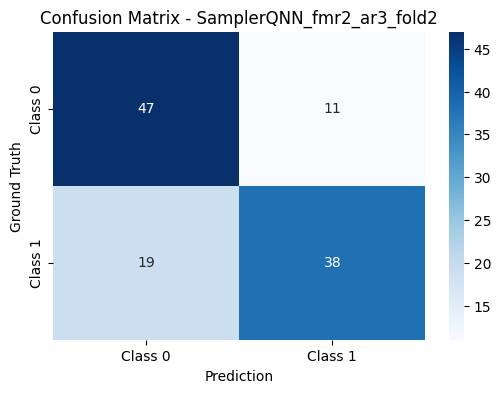

Classification report:
              precision    recall  f1-score   support

     Class 0       0.71      0.81      0.76        58
     Class 1       0.78      0.67      0.72        57

    accuracy                           0.74       115
   macro avg       0.74      0.74      0.74       115
weighted avg       0.74      0.74      0.74       115

Averaging method: macro
Metrics:
	TP: 38.0
	FP: 11.0
	FN: 19.0
	TN: 47.0
	TPR: 0.6667
	SPC: 0.8103
	PPV: 0.7755
	F1: 0.717
	ACC: 0.7391
	NPV: 0.7121
	FPR: 0.1897
	FDR: 0.2245
	FNR: 0.3333
	MCC: 0.4823
Fold time: 148 seconds
Fold 3:


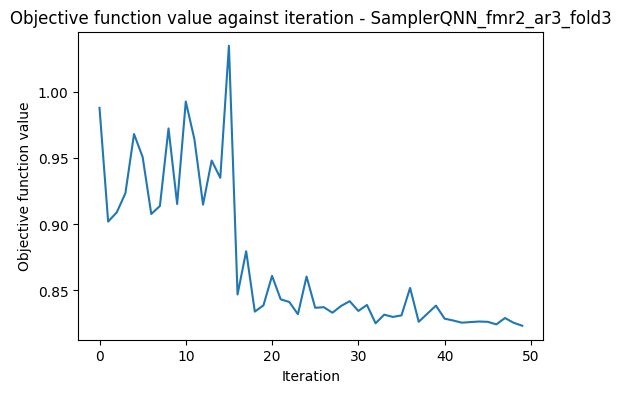

Final loss: 0.8232903770997287
Validation score: 0.6842105263157895


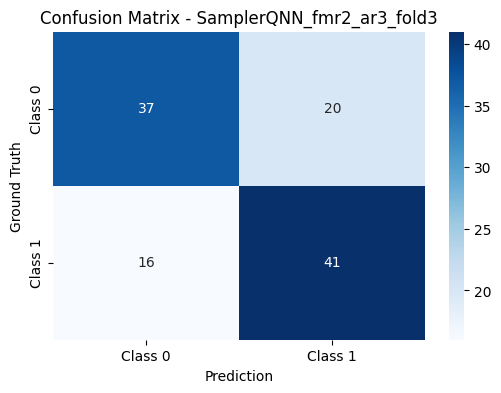

Classification report:
              precision    recall  f1-score   support

     Class 0       0.70      0.65      0.67        57
     Class 1       0.67      0.72      0.69        57

    accuracy                           0.68       114
   macro avg       0.69      0.68      0.68       114
weighted avg       0.69      0.68      0.68       114

Averaging method: macro
Metrics:
	TP: 41.0
	FP: 20.0
	FN: 16.0
	TN: 37.0
	TPR: 0.7193
	SPC: 0.6491
	PPV: 0.6721
	F1: 0.6949
	ACC: 0.6842
	NPV: 0.6981
	FPR: 0.3509
	FDR: 0.3279
	FNR: 0.2807
	MCC: 0.3693
Fold time: 146 seconds
Fold 4:


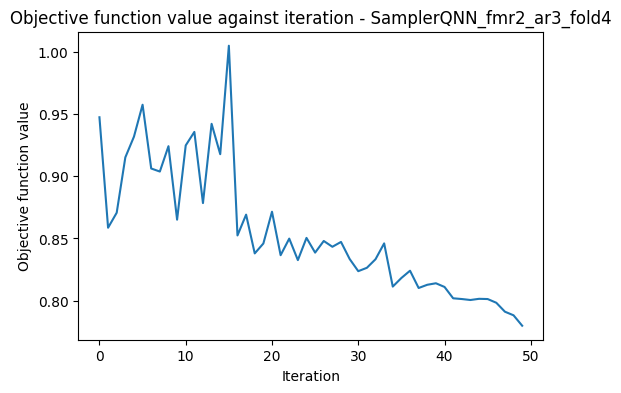

Final loss: 0.7799795299546829
Validation score: 0.7192982456140351


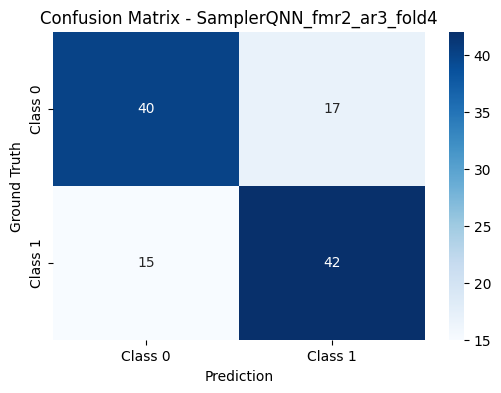

Classification report:
              precision    recall  f1-score   support

     Class 0       0.73      0.70      0.71        57
     Class 1       0.71      0.74      0.72        57

    accuracy                           0.72       114
   macro avg       0.72      0.72      0.72       114
weighted avg       0.72      0.72      0.72       114

Averaging method: macro
Metrics:
	TP: 42.0
	FP: 17.0
	FN: 15.0
	TN: 40.0
	TPR: 0.7368
	SPC: 0.7018
	PPV: 0.7119
	F1: 0.7241
	ACC: 0.7193
	NPV: 0.7273
	FPR: 0.2982
	FDR: 0.2881
	FNR: 0.2632
	MCC: 0.4389
Fold time: 145 seconds
Fold 5:


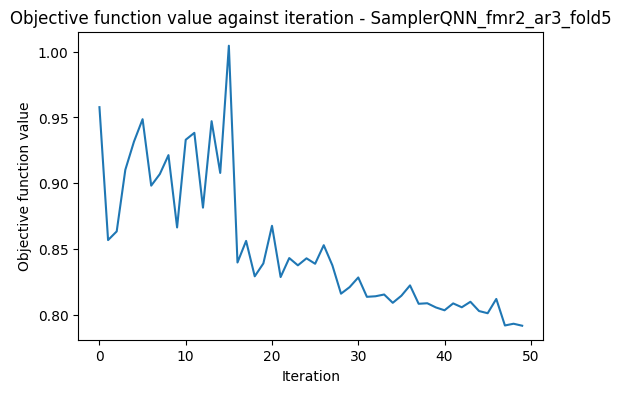

Final loss: 0.7914777707835585
Validation score: 0.6754385964912281


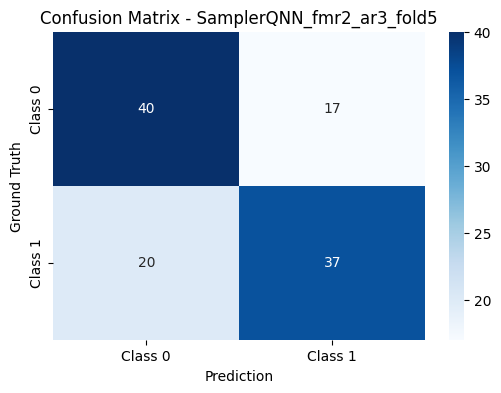

Classification report:
              precision    recall  f1-score   support

     Class 0       0.67      0.70      0.68        57
     Class 1       0.69      0.65      0.67        57

    accuracy                           0.68       114
   macro avg       0.68      0.68      0.68       114
weighted avg       0.68      0.68      0.68       114

Averaging method: macro
Metrics:
	TP: 37.0
	FP: 17.0
	FN: 20.0
	TN: 40.0
	TPR: 0.6491
	SPC: 0.7018
	PPV: 0.6852
	F1: 0.6667
	ACC: 0.6754
	NPV: 0.6667
	FPR: 0.2982
	FDR: 0.3148
	FNR: 0.3509
	MCC: 0.3514
Fold time: 149 seconds
Mean validation loss: 0.7987243356251501
Parameter combination 3/12
Model: SamplerQNN, Epochs: 50, Feature map reps: 3, Ansatz reps: 2


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


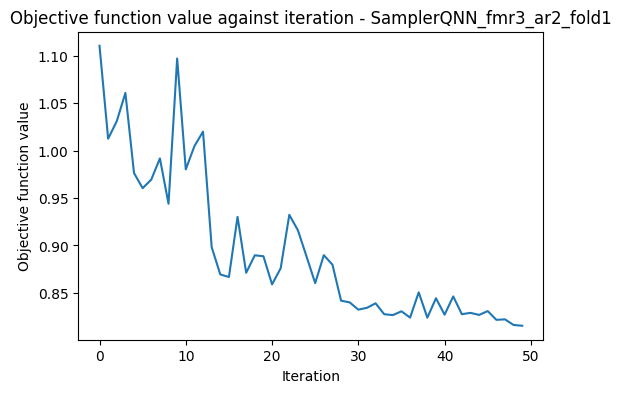

Final loss: 0.815271441575889
Validation score: 0.7130434782608696


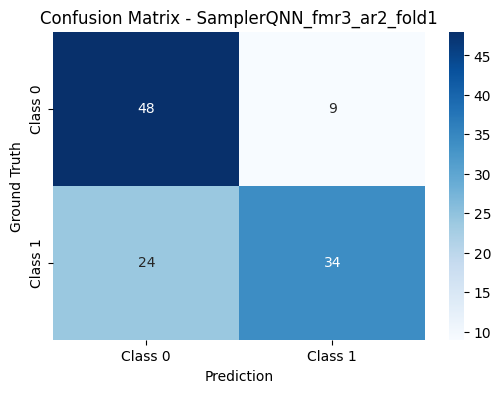

Classification report:
              precision    recall  f1-score   support

     Class 0       0.67      0.84      0.74        57
     Class 1       0.79      0.59      0.67        58

    accuracy                           0.71       115
   macro avg       0.73      0.71      0.71       115
weighted avg       0.73      0.71      0.71       115

Averaging method: macro
Metrics:
	TP: 34.0
	FP: 9.0
	FN: 24.0
	TN: 48.0
	TPR: 0.5862
	SPC: 0.8421
	PPV: 0.7907
	F1: 0.6733
	ACC: 0.713
	NPV: 0.6667
	FPR: 0.1579
	FDR: 0.2093
	FNR: 0.4138
	MCC: 0.4426
Fold time: 179 seconds
Fold 2:


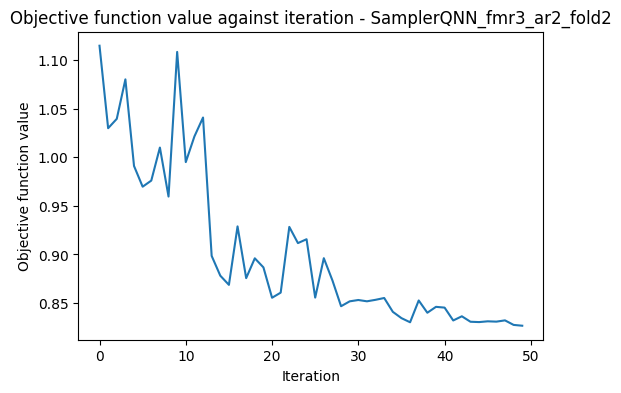

Final loss: 0.8266042247178792
Validation score: 0.7130434782608696


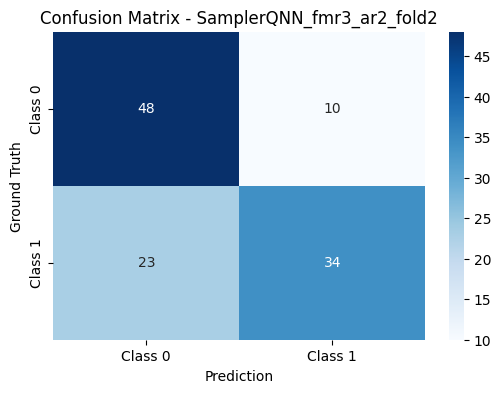

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.83      0.74        58
     Class 1       0.77      0.60      0.67        57

    accuracy                           0.71       115
   macro avg       0.72      0.71      0.71       115
weighted avg       0.72      0.71      0.71       115

Averaging method: macro
Metrics:
	TP: 34.0
	FP: 10.0
	FN: 23.0
	TN: 48.0
	TPR: 0.5965
	SPC: 0.8276
	PPV: 0.7727
	F1: 0.6733
	ACC: 0.713
	NPV: 0.6761
	FPR: 0.1724
	FDR: 0.2273
	FNR: 0.4035
	MCC: 0.4363
Fold time: 179 seconds
Fold 3:


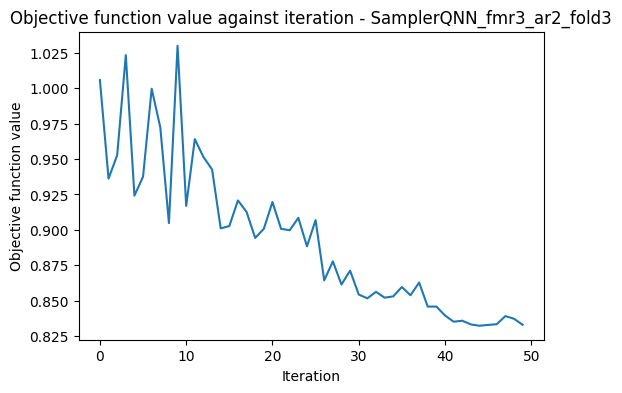

Final loss: 0.8329818498864697
Validation score: 0.6842105263157895


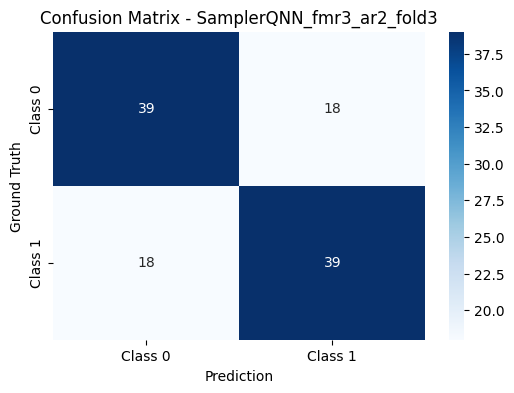

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.68      0.68        57
     Class 1       0.68      0.68      0.68        57

    accuracy                           0.68       114
   macro avg       0.68      0.68      0.68       114
weighted avg       0.68      0.68      0.68       114

Averaging method: macro
Metrics:
	TP: 39.0
	FP: 18.0
	FN: 18.0
	TN: 39.0
	TPR: 0.6842
	SPC: 0.6842
	PPV: 0.6842
	F1: 0.6842
	ACC: 0.6842
	NPV: 0.6842
	FPR: 0.3158
	FDR: 0.3158
	FNR: 0.3158
	MCC: 0.3684
Fold time: 172 seconds
Fold 4:


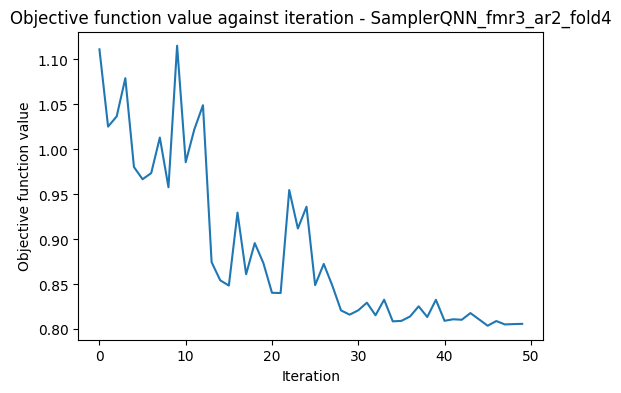

Final loss: 0.8061377836311929
Validation score: 0.7017543859649122


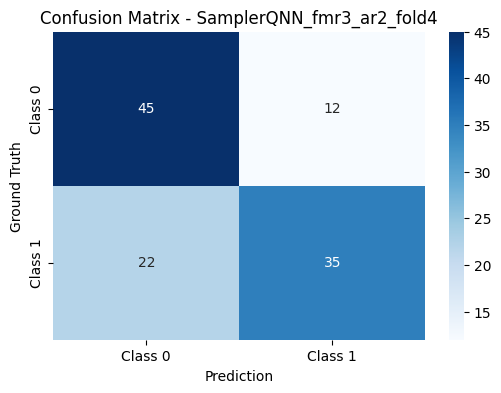

Classification report:
              precision    recall  f1-score   support

     Class 0       0.67      0.79      0.73        57
     Class 1       0.74      0.61      0.67        57

    accuracy                           0.70       114
   macro avg       0.71      0.70      0.70       114
weighted avg       0.71      0.70      0.70       114

Averaging method: macro
Metrics:
	TP: 35.0
	FP: 12.0
	FN: 22.0
	TN: 45.0
	TPR: 0.614
	SPC: 0.7895
	PPV: 0.7447
	F1: 0.6731
	ACC: 0.7018
	NPV: 0.6716
	FPR: 0.2105
	FDR: 0.2553
	FNR: 0.386
	MCC: 0.4099
Fold time: 171 seconds
Fold 5:


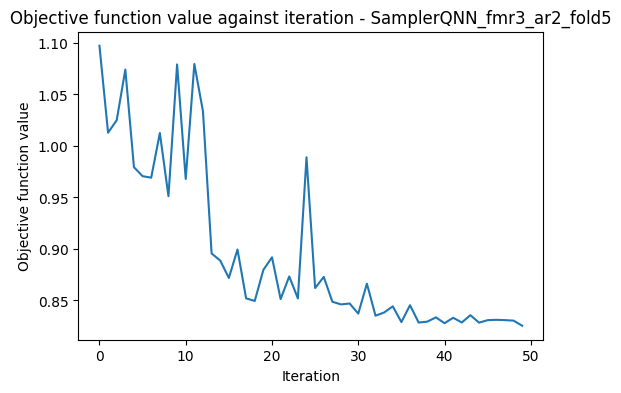

Final loss: 0.8254404126742505
Validation score: 0.6842105263157895


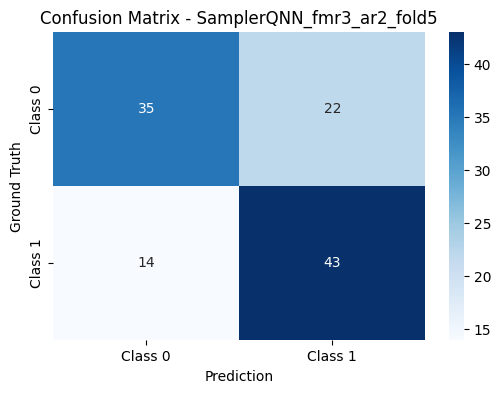

Classification report:
              precision    recall  f1-score   support

     Class 0       0.71      0.61      0.66        57
     Class 1       0.66      0.75      0.70        57

    accuracy                           0.68       114
   macro avg       0.69      0.68      0.68       114
weighted avg       0.69      0.68      0.68       114

Averaging method: macro
Metrics:
	TP: 43.0
	FP: 22.0
	FN: 14.0
	TN: 35.0
	TPR: 0.7544
	SPC: 0.614
	PPV: 0.6615
	F1: 0.7049
	ACC: 0.6842
	NPV: 0.7143
	FPR: 0.386
	FDR: 0.3385
	FNR: 0.2456
	MCC: 0.3721
Fold time: 172 seconds
Mean validation loss: 0.8212871424971363
Parameter combination 4/12
Model: SamplerQNN, Epochs: 50, Feature map reps: 3, Ansatz reps: 3


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


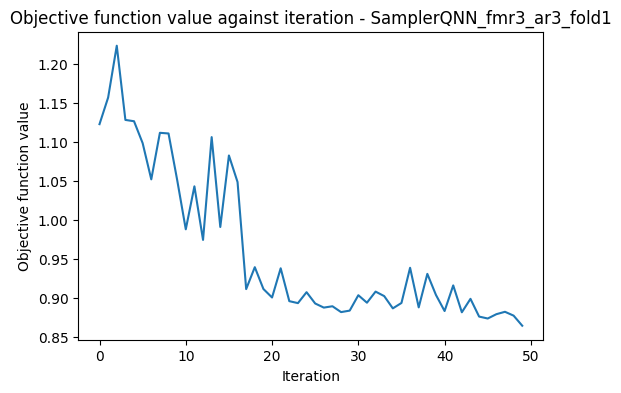

Final loss: 0.8648616991648685
Validation score: 0.6695652173913044


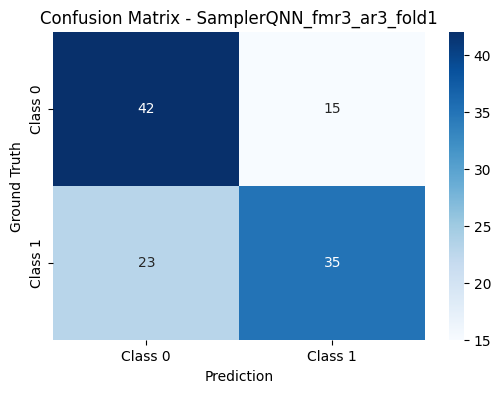

Classification report:
              precision    recall  f1-score   support

     Class 0       0.65      0.74      0.69        57
     Class 1       0.70      0.60      0.65        58

    accuracy                           0.67       115
   macro avg       0.67      0.67      0.67       115
weighted avg       0.67      0.67      0.67       115

Averaging method: macro
Metrics:
	TP: 35.0
	FP: 15.0
	FN: 23.0
	TN: 42.0
	TPR: 0.6034
	SPC: 0.7368
	PPV: 0.7
	F1: 0.6481
	ACC: 0.6696
	NPV: 0.6462
	FPR: 0.2632
	FDR: 0.3
	FNR: 0.3966
	MCC: 0.3432
Fold time: 183 seconds
Fold 2:


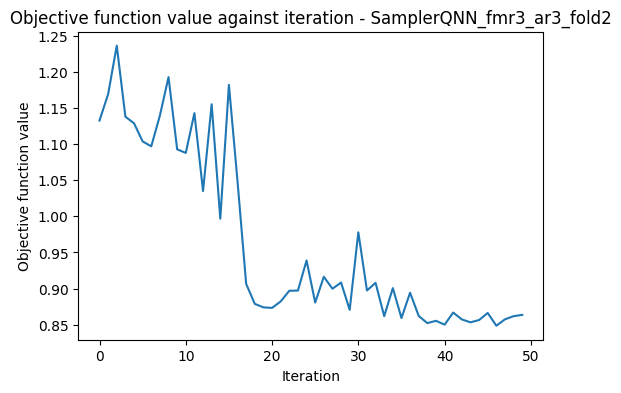

Final loss: 0.8635769996709914
Validation score: 0.7652173913043478


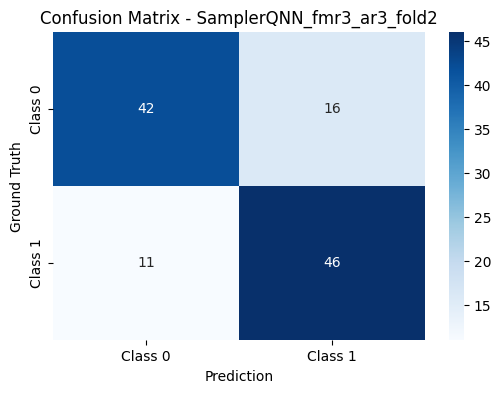

Classification report:
              precision    recall  f1-score   support

     Class 0       0.79      0.72      0.76        58
     Class 1       0.74      0.81      0.77        57

    accuracy                           0.77       115
   macro avg       0.77      0.77      0.76       115
weighted avg       0.77      0.77      0.76       115

Averaging method: macro
Metrics:
	TP: 46.0
	FP: 16.0
	FN: 11.0
	TN: 42.0
	TPR: 0.807
	SPC: 0.7241
	PPV: 0.7419
	F1: 0.7731
	ACC: 0.7652
	NPV: 0.7925
	FPR: 0.2759
	FDR: 0.2581
	FNR: 0.193
	MCC: 0.5328
Fold time: 182 seconds
Fold 3:


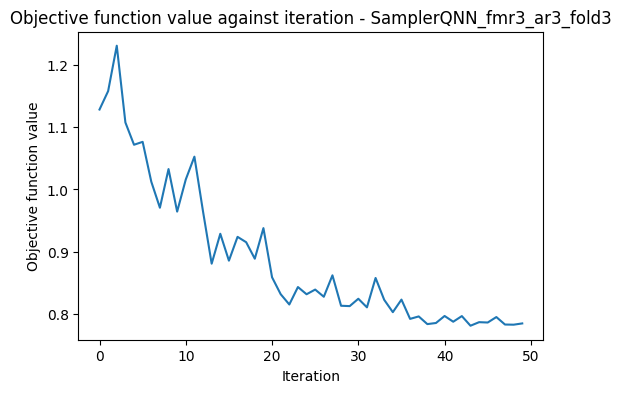

Final loss: 0.7852836588616268
Validation score: 0.7105263157894737


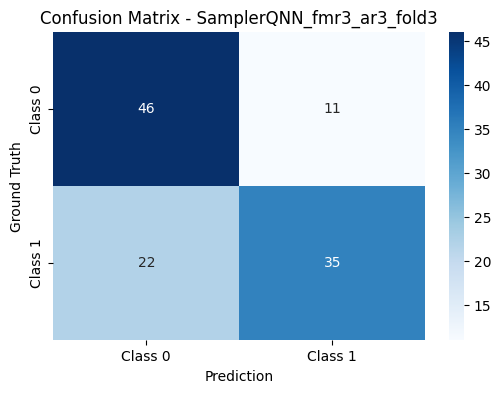

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.81      0.74        57
     Class 1       0.76      0.61      0.68        57

    accuracy                           0.71       114
   macro avg       0.72      0.71      0.71       114
weighted avg       0.72      0.71      0.71       114

Averaging method: macro
Metrics:
	TP: 35.0
	FP: 11.0
	FN: 22.0
	TN: 46.0
	TPR: 0.614
	SPC: 0.807
	PPV: 0.7609
	F1: 0.6796
	ACC: 0.7105
	NPV: 0.6765
	FPR: 0.193
	FDR: 0.2391
	FNR: 0.386
	MCC: 0.4291
Fold time: 181 seconds
Fold 4:


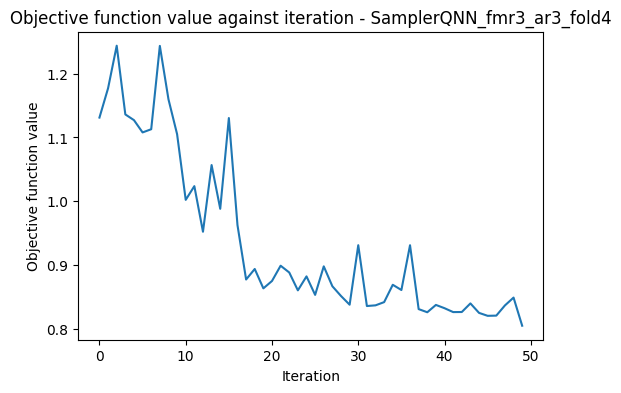

Final loss: 0.8052162580336343
Validation score: 0.6929824561403509


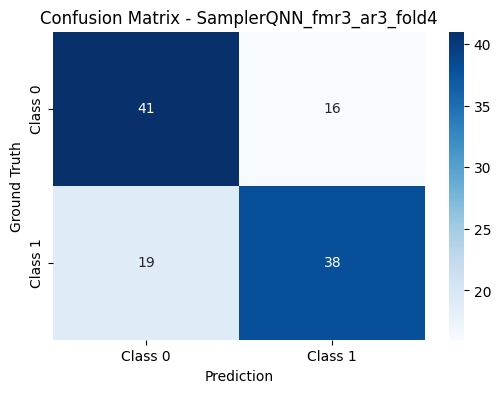

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.72      0.70        57
     Class 1       0.70      0.67      0.68        57

    accuracy                           0.69       114
   macro avg       0.69      0.69      0.69       114
weighted avg       0.69      0.69      0.69       114

Averaging method: macro
Metrics:
	TP: 38.0
	FP: 16.0
	FN: 19.0
	TN: 41.0
	TPR: 0.6667
	SPC: 0.7193
	PPV: 0.7037
	F1: 0.6847
	ACC: 0.693
	NPV: 0.6833
	FPR: 0.2807
	FDR: 0.2963
	FNR: 0.3333
	MCC: 0.3865
Fold time: 180 seconds
Fold 5:


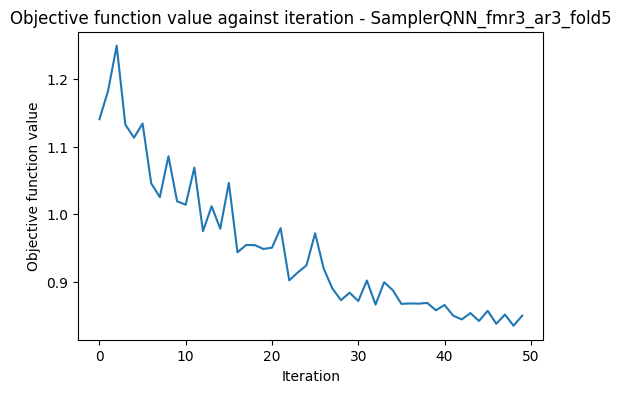

Final loss: 0.8501089745399195
Validation score: 0.7017543859649122


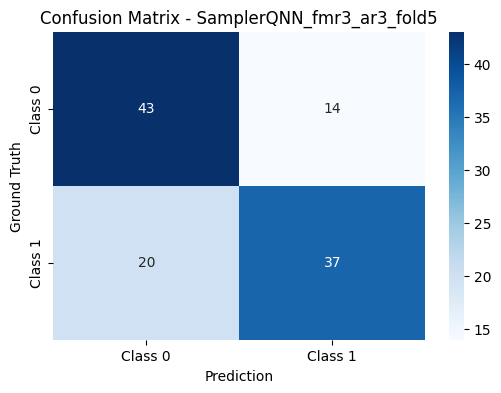

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.75      0.72        57
     Class 1       0.73      0.65      0.69        57

    accuracy                           0.70       114
   macro avg       0.70      0.70      0.70       114
weighted avg       0.70      0.70      0.70       114

Averaging method: macro
Metrics:
	TP: 37.0
	FP: 14.0
	FN: 20.0
	TN: 43.0
	TPR: 0.6491
	SPC: 0.7544
	PPV: 0.7255
	F1: 0.6852
	ACC: 0.7018
	NPV: 0.6825
	FPR: 0.2456
	FDR: 0.2745
	FNR: 0.3509
	MCC: 0.4058
Fold time: 181 seconds
Mean validation loss: 0.833809518054208
Parameter combination 5/12
Model: SamplerQNN, Epochs: 100, Feature map reps: 2, Ansatz reps: 2


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


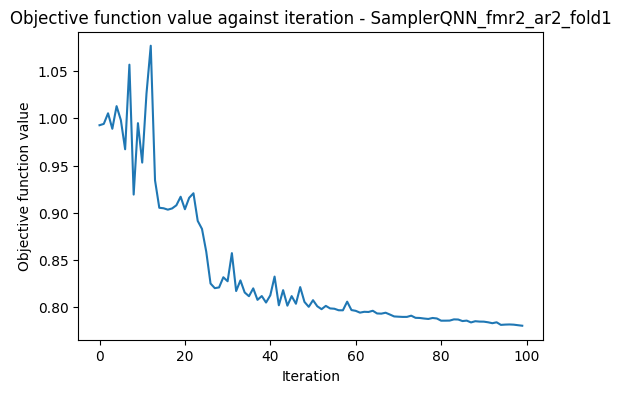

Final loss: 0.7804430695199608
Validation score: 0.7130434782608696


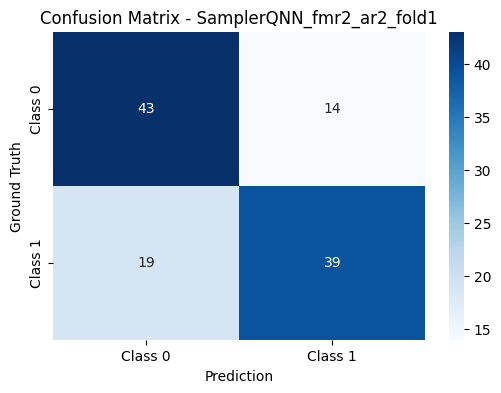

Classification report:
              precision    recall  f1-score   support

     Class 0       0.69      0.75      0.72        57
     Class 1       0.74      0.67      0.70        58

    accuracy                           0.71       115
   macro avg       0.71      0.71      0.71       115
weighted avg       0.71      0.71      0.71       115

Averaging method: macro
Metrics:
	TP: 39.0
	FP: 14.0
	FN: 19.0
	TN: 43.0
	TPR: 0.6724
	SPC: 0.7544
	PPV: 0.7358
	F1: 0.7027
	ACC: 0.713
	NPV: 0.6935
	FPR: 0.2456
	FDR: 0.2642
	FNR: 0.3276
	MCC: 0.4281
Fold time: 258 seconds
Fold 2:


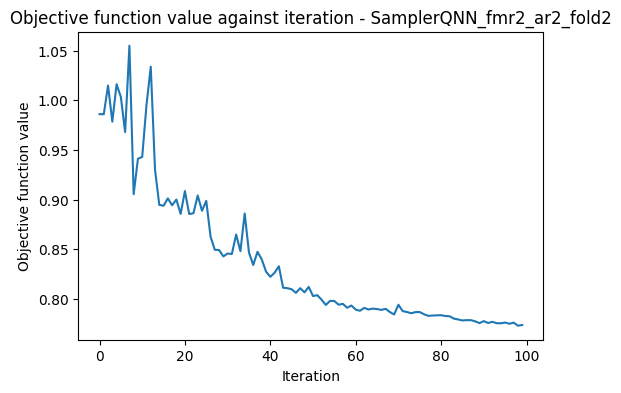

Final loss: 0.7739223751913956
Validation score: 0.7652173913043478


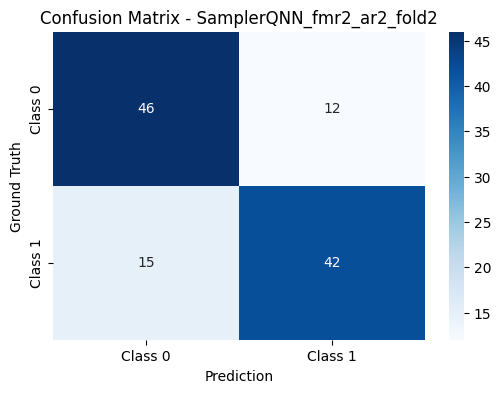

Classification report:
              precision    recall  f1-score   support

     Class 0       0.75      0.79      0.77        58
     Class 1       0.78      0.74      0.76        57

    accuracy                           0.77       115
   macro avg       0.77      0.76      0.76       115
weighted avg       0.77      0.77      0.77       115

Averaging method: macro
Metrics:
	TP: 42.0
	FP: 12.0
	FN: 15.0
	TN: 46.0
	TPR: 0.7368
	SPC: 0.7931
	PPV: 0.7778
	F1: 0.7568
	ACC: 0.7652
	NPV: 0.7541
	FPR: 0.2069
	FDR: 0.2222
	FNR: 0.2632
	MCC: 0.5309
Fold time: 259 seconds
Fold 3:


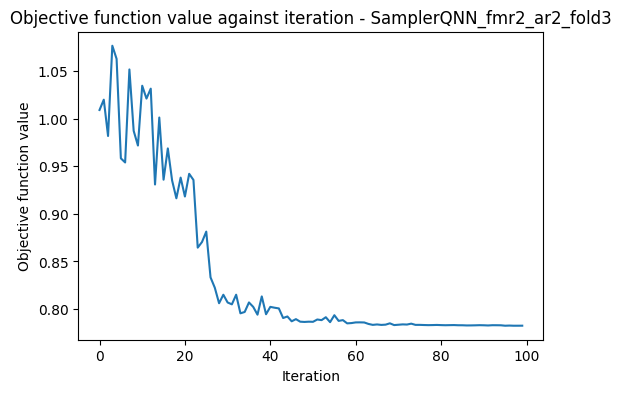

Final loss: 0.7825140618514981
Validation score: 0.7456140350877193


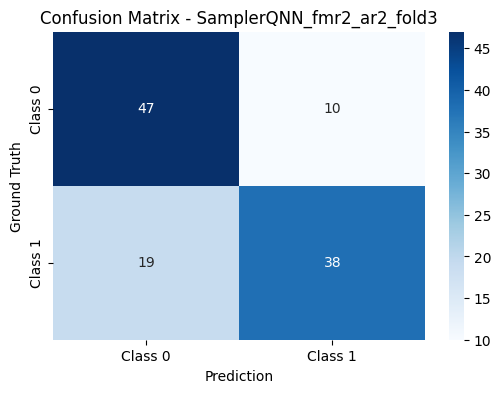

Classification report:
              precision    recall  f1-score   support

     Class 0       0.71      0.82      0.76        57
     Class 1       0.79      0.67      0.72        57

    accuracy                           0.75       114
   macro avg       0.75      0.75      0.74       114
weighted avg       0.75      0.75      0.74       114

Averaging method: macro
Metrics:
	TP: 38.0
	FP: 10.0
	FN: 19.0
	TN: 47.0
	TPR: 0.6667
	SPC: 0.8246
	PPV: 0.7917
	F1: 0.7238
	ACC: 0.7456
	NPV: 0.7121
	FPR: 0.1754
	FDR: 0.2083
	FNR: 0.3333
	MCC: 0.4975
Fold time: 259 seconds
Fold 4:


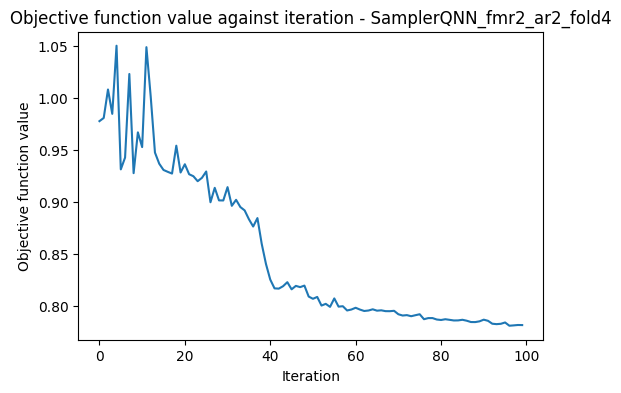

Final loss: 0.781453200443842
Validation score: 0.6929824561403509


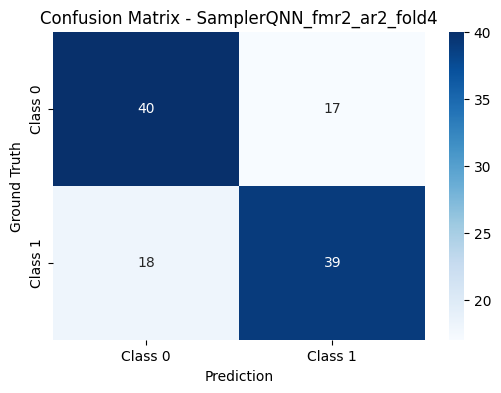

Classification report:
              precision    recall  f1-score   support

     Class 0       0.69      0.70      0.70        57
     Class 1       0.70      0.68      0.69        57

    accuracy                           0.69       114
   macro avg       0.69      0.69      0.69       114
weighted avg       0.69      0.69      0.69       114

Averaging method: macro
Metrics:
	TP: 39.0
	FP: 17.0
	FN: 18.0
	TN: 40.0
	TPR: 0.6842
	SPC: 0.7018
	PPV: 0.6964
	F1: 0.6903
	ACC: 0.693
	NPV: 0.6897
	FPR: 0.2982
	FDR: 0.3036
	FNR: 0.3158
	MCC: 0.386
Fold time: 259 seconds
Fold 5:


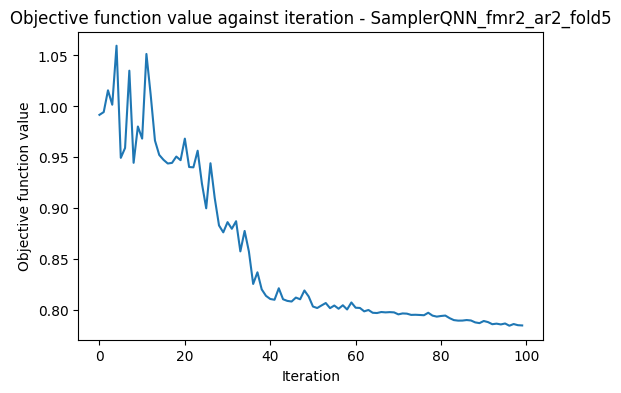

Final loss: 0.7849508687271393
Validation score: 0.7017543859649122


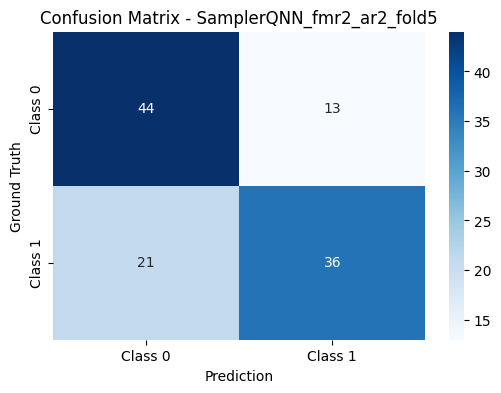

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.77      0.72        57
     Class 1       0.73      0.63      0.68        57

    accuracy                           0.70       114
   macro avg       0.71      0.70      0.70       114
weighted avg       0.71      0.70      0.70       114

Averaging method: macro
Metrics:
	TP: 36.0
	FP: 13.0
	FN: 21.0
	TN: 44.0
	TPR: 0.6316
	SPC: 0.7719
	PPV: 0.7347
	F1: 0.6792
	ACC: 0.7018
	NPV: 0.6769
	FPR: 0.2281
	FDR: 0.2653
	FNR: 0.3684
	MCC: 0.4075
Fold time: 258 seconds
Mean validation loss: 0.7806567151467672
Parameter combination 6/12
Model: SamplerQNN, Epochs: 100, Feature map reps: 2, Ansatz reps: 3


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


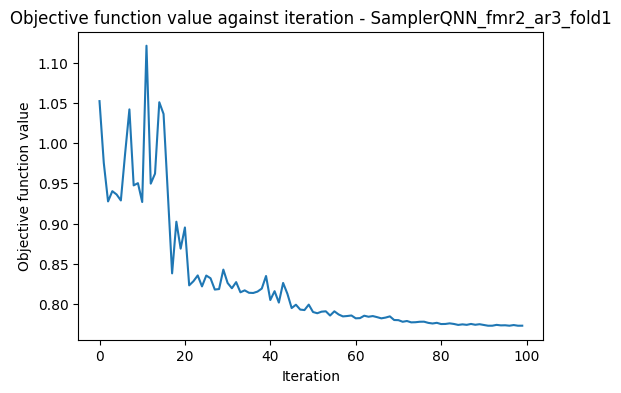

Final loss: 0.7733257217279136
Validation score: 0.7217391304347827


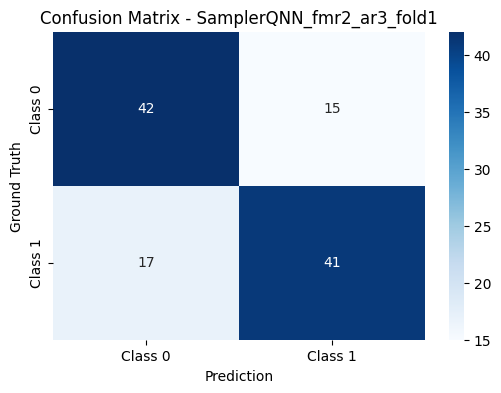

Classification report:
              precision    recall  f1-score   support

     Class 0       0.71      0.74      0.72        57
     Class 1       0.73      0.71      0.72        58

    accuracy                           0.72       115
   macro avg       0.72      0.72      0.72       115
weighted avg       0.72      0.72      0.72       115

Averaging method: macro
Metrics:
	TP: 41.0
	FP: 15.0
	FN: 17.0
	TN: 42.0
	TPR: 0.7069
	SPC: 0.7368
	PPV: 0.7321
	F1: 0.7193
	ACC: 0.7217
	NPV: 0.7119
	FPR: 0.2632
	FDR: 0.2679
	FNR: 0.2931
	MCC: 0.4439
Fold time: 281 seconds
Fold 2:


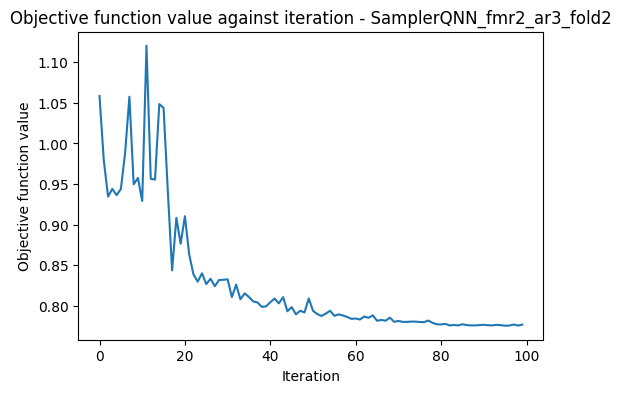

Final loss: 0.7769002001090277
Validation score: 0.782608695652174


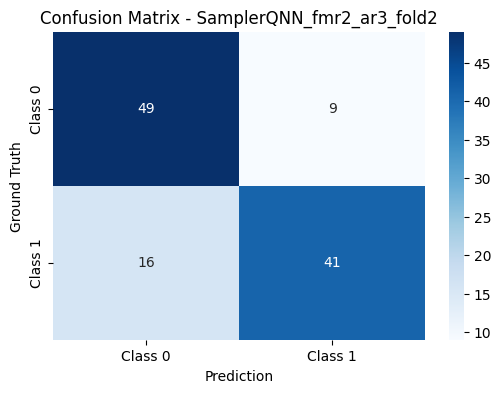

Classification report:
              precision    recall  f1-score   support

     Class 0       0.75      0.84      0.80        58
     Class 1       0.82      0.72      0.77        57

    accuracy                           0.78       115
   macro avg       0.79      0.78      0.78       115
weighted avg       0.79      0.78      0.78       115

Averaging method: macro
Metrics:
	TP: 41.0
	FP: 9.0
	FN: 16.0
	TN: 49.0
	TPR: 0.7193
	SPC: 0.8448
	PPV: 0.82
	F1: 0.7664
	ACC: 0.7826
	NPV: 0.7538
	FPR: 0.1552
	FDR: 0.18
	FNR: 0.2807
	MCC: 0.569
Fold time: 281 seconds
Fold 3:


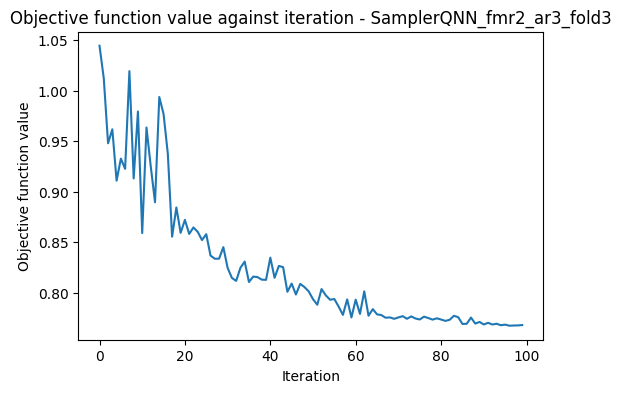

Final loss: 0.7682616057257652
Validation score: 0.7017543859649122


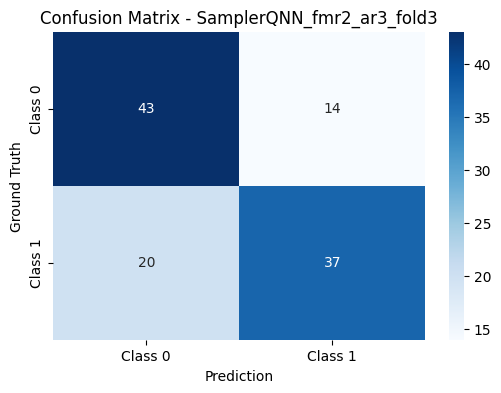

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.75      0.72        57
     Class 1       0.73      0.65      0.69        57

    accuracy                           0.70       114
   macro avg       0.70      0.70      0.70       114
weighted avg       0.70      0.70      0.70       114

Averaging method: macro
Metrics:
	TP: 37.0
	FP: 14.0
	FN: 20.0
	TN: 43.0
	TPR: 0.6491
	SPC: 0.7544
	PPV: 0.7255
	F1: 0.6852
	ACC: 0.7018
	NPV: 0.6825
	FPR: 0.2456
	FDR: 0.2745
	FNR: 0.3509
	MCC: 0.4058
Fold time: 281 seconds
Fold 4:


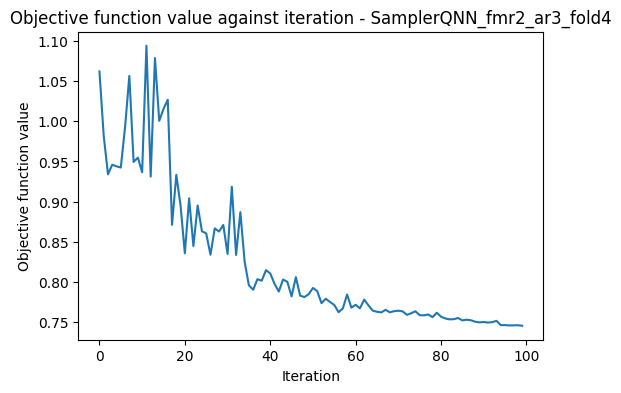

Final loss: 0.7456651076870539
Validation score: 0.7017543859649122


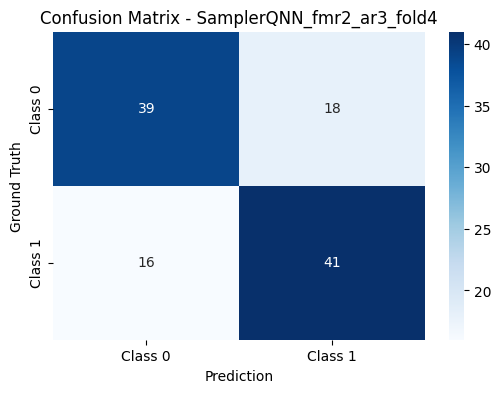

Classification report:
              precision    recall  f1-score   support

     Class 0       0.71      0.68      0.70        57
     Class 1       0.69      0.72      0.71        57

    accuracy                           0.70       114
   macro avg       0.70      0.70      0.70       114
weighted avg       0.70      0.70      0.70       114

Averaging method: macro
Metrics:
	TP: 41.0
	FP: 18.0
	FN: 16.0
	TN: 39.0
	TPR: 0.7193
	SPC: 0.6842
	PPV: 0.6949
	F1: 0.7069
	ACC: 0.7018
	NPV: 0.7091
	FPR: 0.3158
	FDR: 0.3051
	FNR: 0.2807
	MCC: 0.4038
Fold time: 282 seconds
Fold 5:


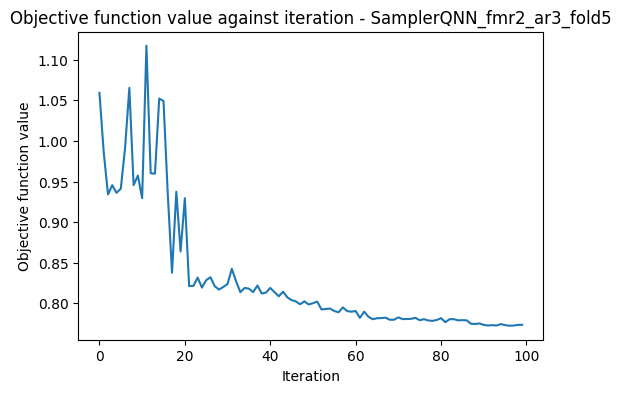

Final loss: 0.7736279097785288
Validation score: 0.6754385964912281


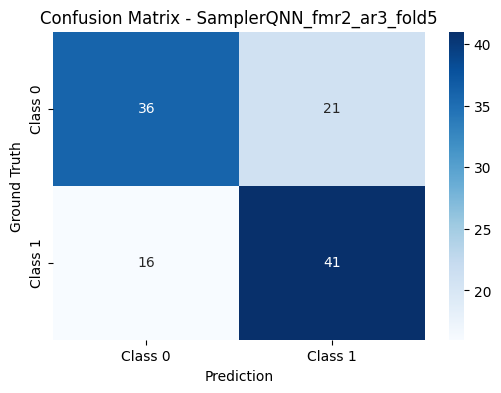

Classification report:
              precision    recall  f1-score   support

     Class 0       0.69      0.63      0.66        57
     Class 1       0.66      0.72      0.69        57

    accuracy                           0.68       114
   macro avg       0.68      0.68      0.67       114
weighted avg       0.68      0.68      0.67       114

Averaging method: macro
Metrics:
	TP: 41.0
	FP: 21.0
	FN: 16.0
	TN: 36.0
	TPR: 0.7193
	SPC: 0.6316
	PPV: 0.6613
	F1: 0.6891
	ACC: 0.6754
	NPV: 0.6923
	FPR: 0.3684
	FDR: 0.3387
	FNR: 0.2807
	MCC: 0.3522
Fold time: 281 seconds
Mean validation loss: 0.7675561090056578
Parameter combination 7/12
Model: SamplerQNN, Epochs: 100, Feature map reps: 3, Ansatz reps: 2


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


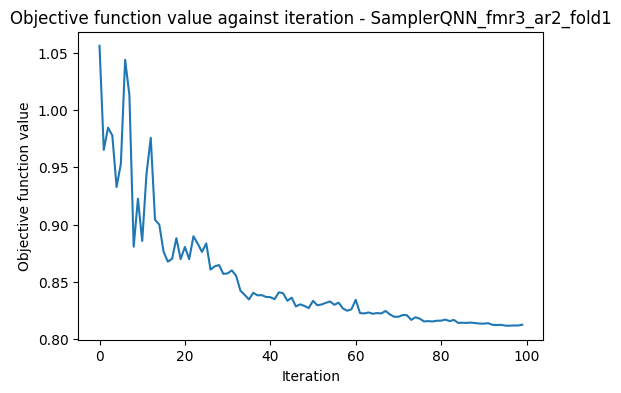

Final loss: 0.8125490131098312
Validation score: 0.7391304347826086


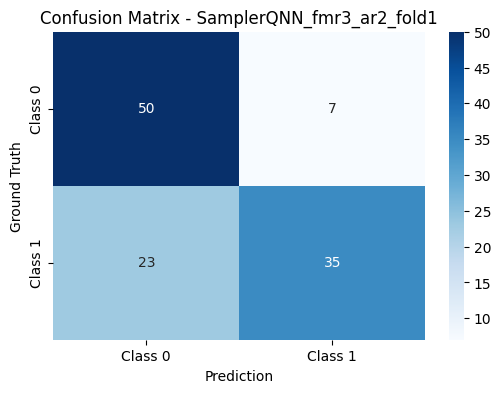

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.88      0.77        57
     Class 1       0.83      0.60      0.70        58

    accuracy                           0.74       115
   macro avg       0.76      0.74      0.73       115
weighted avg       0.76      0.74      0.73       115

Averaging method: macro
Metrics:
	TP: 35.0
	FP: 7.0
	FN: 23.0
	TN: 50.0
	TPR: 0.6034
	SPC: 0.8772
	PPV: 0.8333
	F1: 0.7
	ACC: 0.7391
	NPV: 0.6849
	FPR: 0.1228
	FDR: 0.1667
	FNR: 0.3966
	MCC: 0.4991
Fold time: 333 seconds
Fold 2:


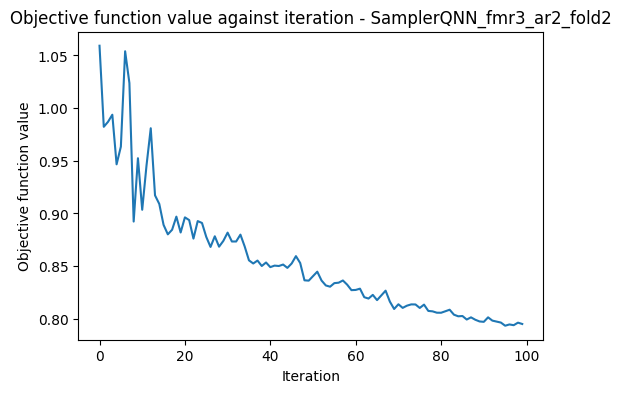

Final loss: 0.795032473201556
Validation score: 0.7304347826086957


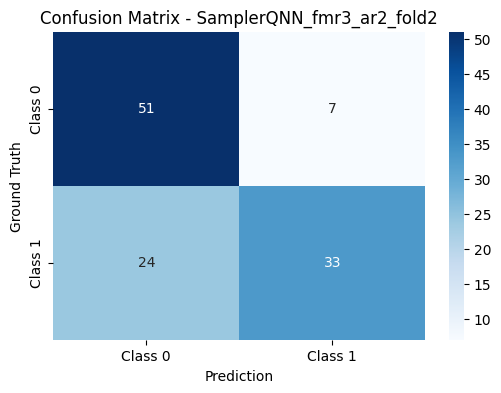

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.88      0.77        58
     Class 1       0.82      0.58      0.68        57

    accuracy                           0.73       115
   macro avg       0.75      0.73      0.72       115
weighted avg       0.75      0.73      0.72       115

Averaging method: macro
Metrics:
	TP: 33.0
	FP: 7.0
	FN: 24.0
	TN: 51.0
	TPR: 0.5789
	SPC: 0.8793
	PPV: 0.825
	F1: 0.6804
	ACC: 0.7304
	NPV: 0.68
	FPR: 0.1207
	FDR: 0.175
	FNR: 0.4211
	MCC: 0.4811
Fold time: 372 seconds
Fold 3:


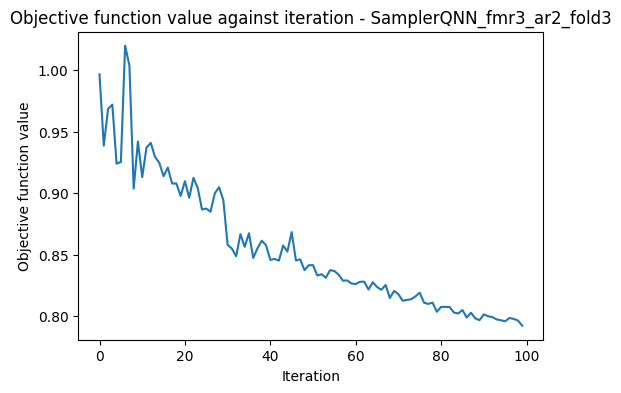

Final loss: 0.792384526195495
Validation score: 0.6929824561403509


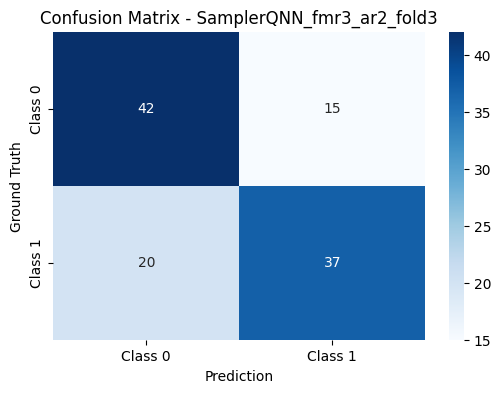

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.74      0.71        57
     Class 1       0.71      0.65      0.68        57

    accuracy                           0.69       114
   macro avg       0.69      0.69      0.69       114
weighted avg       0.69      0.69      0.69       114

Averaging method: macro
Metrics:
	TP: 37.0
	FP: 15.0
	FN: 20.0
	TN: 42.0
	TPR: 0.6491
	SPC: 0.7368
	PPV: 0.7115
	F1: 0.6789
	ACC: 0.693
	NPV: 0.6774
	FPR: 0.2632
	FDR: 0.2885
	FNR: 0.3509
	MCC: 0.3875
Fold time: 414 seconds
Fold 4:


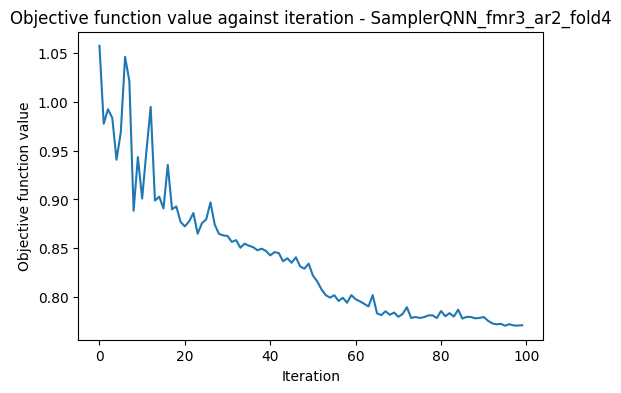

Final loss: 0.7710617705782336
Validation score: 0.6842105263157895


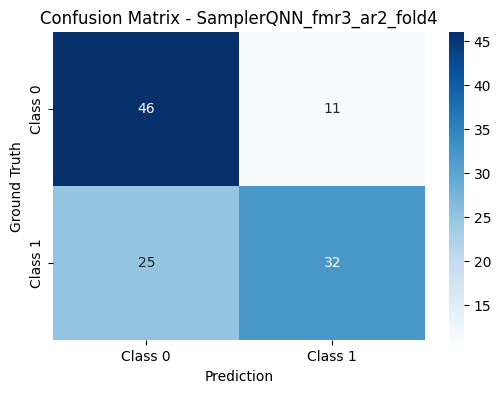

Classification report:
              precision    recall  f1-score   support

     Class 0       0.65      0.81      0.72        57
     Class 1       0.74      0.56      0.64        57

    accuracy                           0.68       114
   macro avg       0.70      0.68      0.68       114
weighted avg       0.70      0.68      0.68       114

Averaging method: macro
Metrics:
	TP: 32.0
	FP: 11.0
	FN: 25.0
	TN: 46.0
	TPR: 0.5614
	SPC: 0.807
	PPV: 0.7442
	F1: 0.64
	ACC: 0.6842
	NPV: 0.6479
	FPR: 0.193
	FDR: 0.2558
	FNR: 0.4386
	MCC: 0.3801
Fold time: 363 seconds
Fold 5:


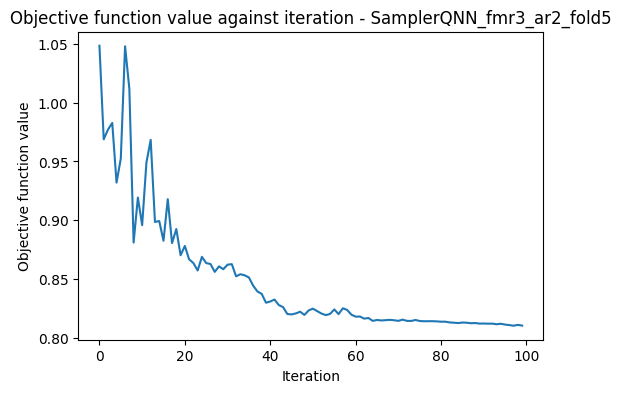

Final loss: 0.8106707308119174
Validation score: 0.6578947368421053


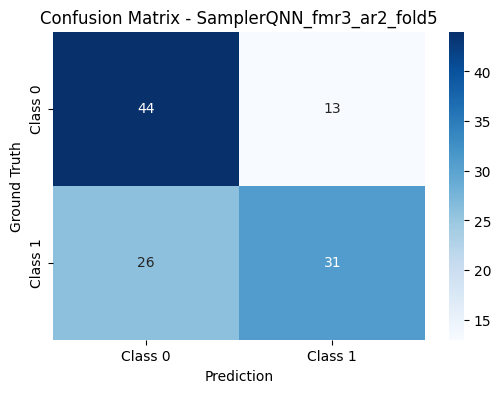

Classification report:
              precision    recall  f1-score   support

     Class 0       0.63      0.77      0.69        57
     Class 1       0.70      0.54      0.61        57

    accuracy                           0.66       114
   macro avg       0.67      0.66      0.65       114
weighted avg       0.67      0.66      0.65       114

Averaging method: macro
Metrics:
	TP: 31.0
	FP: 13.0
	FN: 26.0
	TN: 44.0
	TPR: 0.5439
	SPC: 0.7719
	PPV: 0.7045
	F1: 0.6139
	ACC: 0.6579
	NPV: 0.6286
	FPR: 0.2281
	FDR: 0.2955
	FNR: 0.4561
	MCC: 0.3243
Fold time: 344 seconds
Mean validation loss: 0.7963397027794066
Parameter combination 8/12
Model: SamplerQNN, Epochs: 100, Feature map reps: 3, Ansatz reps: 3


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


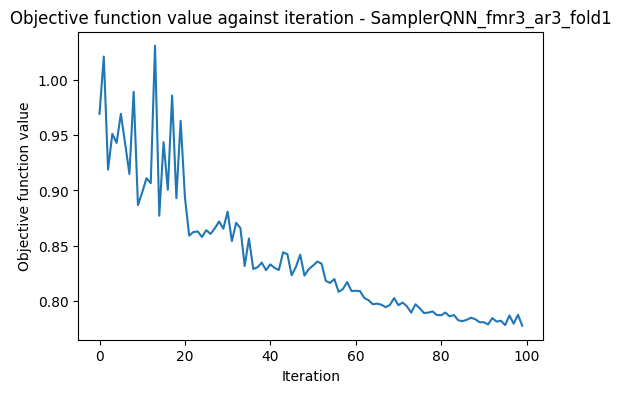

Final loss: 0.7777295561966372
Validation score: 0.782608695652174


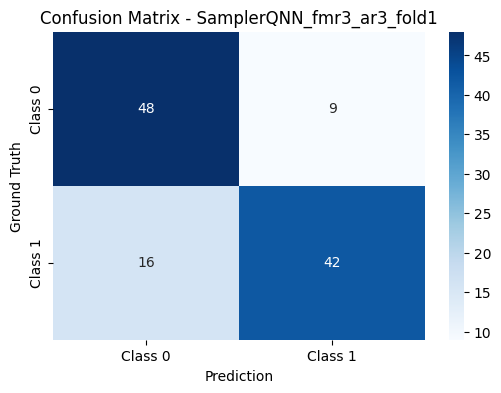

Classification report:
              precision    recall  f1-score   support

     Class 0       0.75      0.84      0.79        57
     Class 1       0.82      0.72      0.77        58

    accuracy                           0.78       115
   macro avg       0.79      0.78      0.78       115
weighted avg       0.79      0.78      0.78       115

Averaging method: macro
Metrics:
	TP: 42.0
	FP: 9.0
	FN: 16.0
	TN: 48.0
	TPR: 0.7241
	SPC: 0.8421
	PPV: 0.8235
	F1: 0.7706
	ACC: 0.7826
	NPV: 0.75
	FPR: 0.1579
	FDR: 0.1765
	FNR: 0.2759
	MCC: 0.5699
Fold time: 359 seconds
Fold 2:


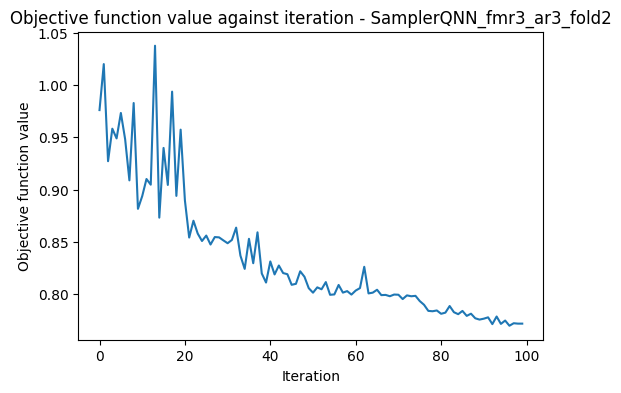

Final loss: 0.7717752817108808
Validation score: 0.7652173913043478


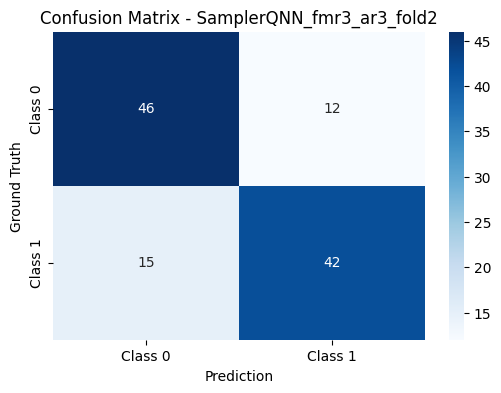

Classification report:
              precision    recall  f1-score   support

     Class 0       0.75      0.79      0.77        58
     Class 1       0.78      0.74      0.76        57

    accuracy                           0.77       115
   macro avg       0.77      0.76      0.76       115
weighted avg       0.77      0.77      0.77       115

Averaging method: macro
Metrics:
	TP: 42.0
	FP: 12.0
	FN: 15.0
	TN: 46.0
	TPR: 0.7368
	SPC: 0.7931
	PPV: 0.7778
	F1: 0.7568
	ACC: 0.7652
	NPV: 0.7541
	FPR: 0.2069
	FDR: 0.2222
	FNR: 0.2632
	MCC: 0.5309
Fold time: 359 seconds
Fold 3:


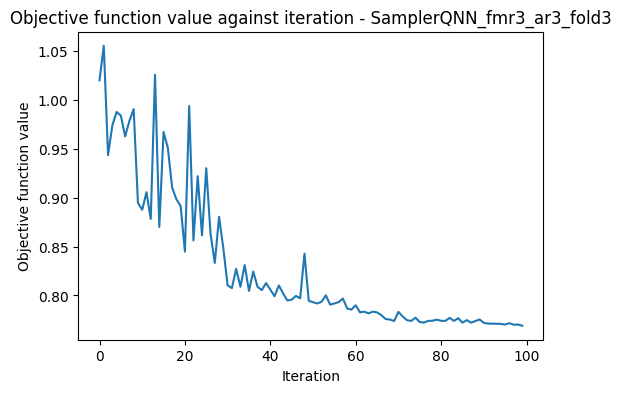

Final loss: 0.7689605022978815
Validation score: 0.7631578947368421


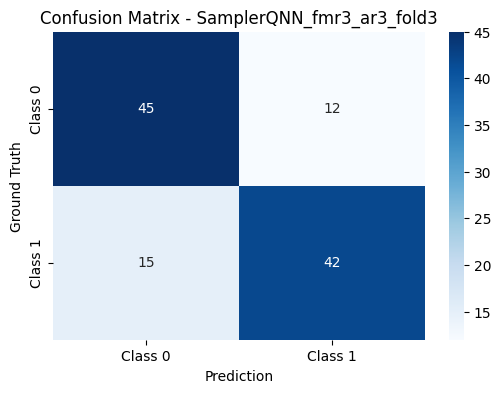

Classification report:
              precision    recall  f1-score   support

     Class 0       0.75      0.79      0.77        57
     Class 1       0.78      0.74      0.76        57

    accuracy                           0.76       114
   macro avg       0.76      0.76      0.76       114
weighted avg       0.76      0.76      0.76       114

Averaging method: macro
Metrics:
	TP: 42.0
	FP: 12.0
	FN: 15.0
	TN: 45.0
	TPR: 0.7368
	SPC: 0.7895
	PPV: 0.7778
	F1: 0.7568
	ACC: 0.7632
	NPV: 0.75
	FPR: 0.2105
	FDR: 0.2222
	FNR: 0.2632
	MCC: 0.527
Fold time: 360 seconds
Fold 4:


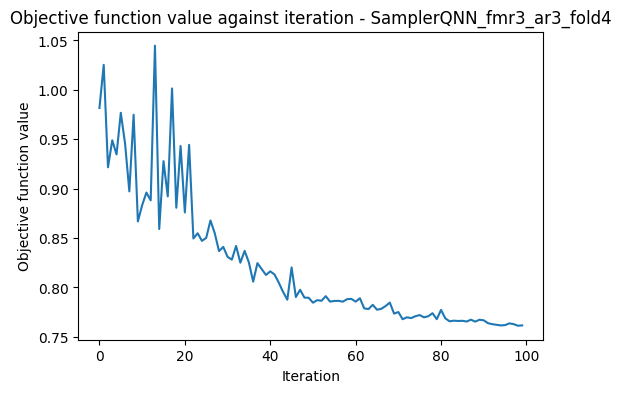

Final loss: 0.7615443714481422
Validation score: 0.7192982456140351


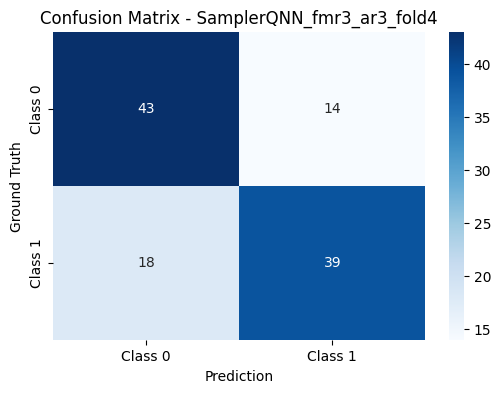

Classification report:
              precision    recall  f1-score   support

     Class 0       0.70      0.75      0.73        57
     Class 1       0.74      0.68      0.71        57

    accuracy                           0.72       114
   macro avg       0.72      0.72      0.72       114
weighted avg       0.72      0.72      0.72       114

Averaging method: macro
Metrics:
	TP: 39.0
	FP: 14.0
	FN: 18.0
	TN: 43.0
	TPR: 0.6842
	SPC: 0.7544
	PPV: 0.7358
	F1: 0.7091
	ACC: 0.7193
	NPV: 0.7049
	FPR: 0.2456
	FDR: 0.2642
	FNR: 0.3158
	MCC: 0.4397
Fold time: 359 seconds
Fold 5:


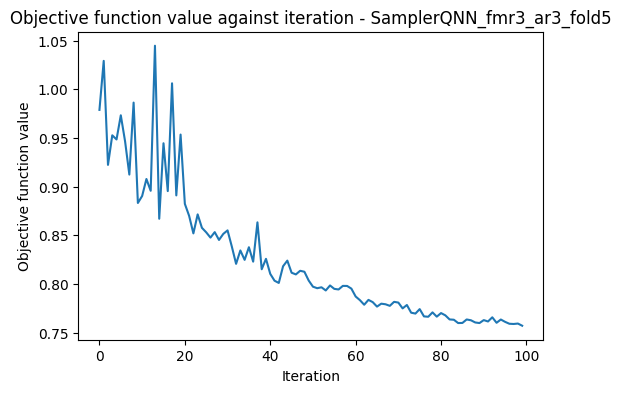

Final loss: 0.757092345145072
Validation score: 0.7280701754385965


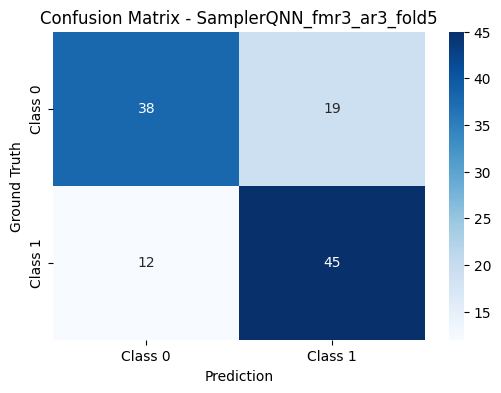

Classification report:
              precision    recall  f1-score   support

     Class 0       0.76      0.67      0.71        57
     Class 1       0.70      0.79      0.74        57

    accuracy                           0.73       114
   macro avg       0.73      0.73      0.73       114
weighted avg       0.73      0.73      0.73       114

Averaging method: macro
Metrics:
	TP: 45.0
	FP: 19.0
	FN: 12.0
	TN: 38.0
	TPR: 0.7895
	SPC: 0.6667
	PPV: 0.7031
	F1: 0.7438
	ACC: 0.7281
	NPV: 0.76
	FPR: 0.3333
	FDR: 0.2969
	FNR: 0.2105
	MCC: 0.4596
Fold time: 359 seconds
Mean validation loss: 0.7674204113597227
Parameter combination 9/12
Model: SamplerQNN, Epochs: 200, Feature map reps: 2, Ansatz reps: 2


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


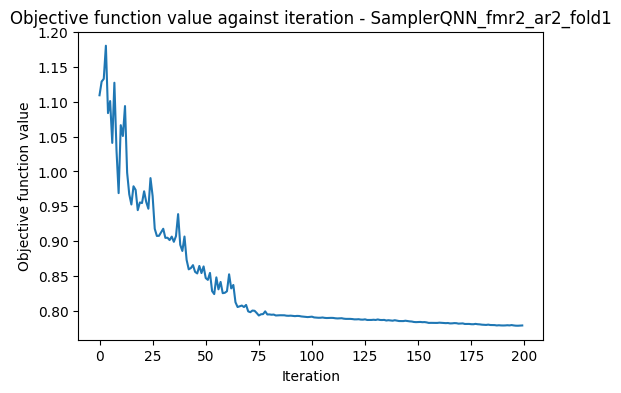

Final loss: 0.7787433180690224
Validation score: 0.7130434782608696


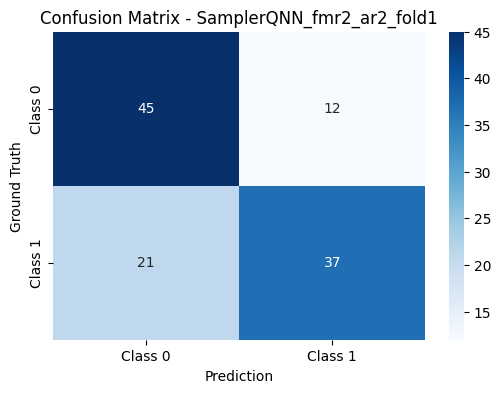

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.79      0.73        57
     Class 1       0.76      0.64      0.69        58

    accuracy                           0.71       115
   macro avg       0.72      0.71      0.71       115
weighted avg       0.72      0.71      0.71       115

Averaging method: macro
Metrics:
	TP: 37.0
	FP: 12.0
	FN: 21.0
	TN: 45.0
	TPR: 0.6379
	SPC: 0.7895
	PPV: 0.7551
	F1: 0.6916
	ACC: 0.713
	NPV: 0.6818
	FPR: 0.2105
	FDR: 0.2449
	FNR: 0.3621
	MCC: 0.4321
Fold time: 515 seconds
Fold 2:


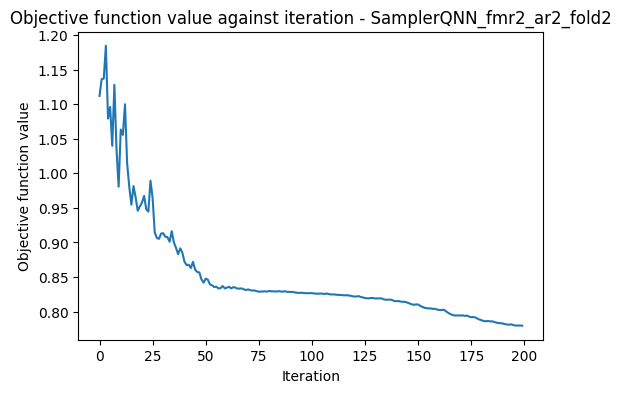

Final loss: 0.7795774531202108
Validation score: 0.7565217391304347


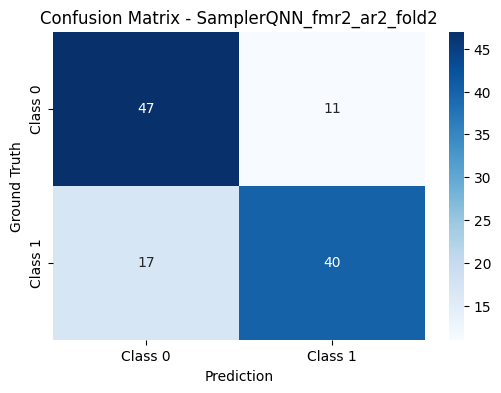

Classification report:
              precision    recall  f1-score   support

     Class 0       0.73      0.81      0.77        58
     Class 1       0.78      0.70      0.74        57

    accuracy                           0.76       115
   macro avg       0.76      0.76      0.76       115
weighted avg       0.76      0.76      0.76       115

Averaging method: macro
Metrics:
	TP: 40.0
	FP: 11.0
	FN: 17.0
	TN: 47.0
	TPR: 0.7018
	SPC: 0.8103
	PPV: 0.7843
	F1: 0.7407
	ACC: 0.7565
	NPV: 0.7344
	FPR: 0.1897
	FDR: 0.2157
	FNR: 0.2982
	MCC: 0.5154
Fold time: 514 seconds
Fold 3:


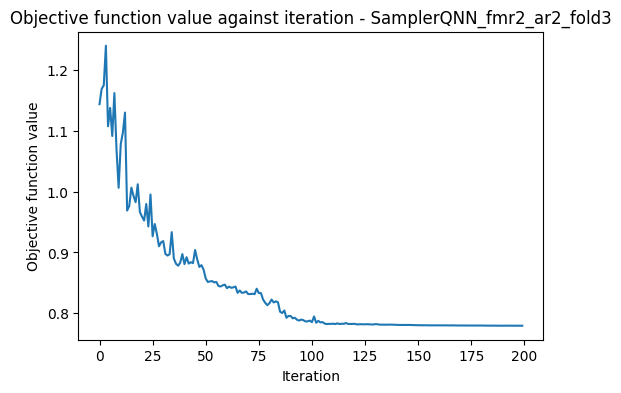

Final loss: 0.7793658242034434
Validation score: 0.7456140350877193


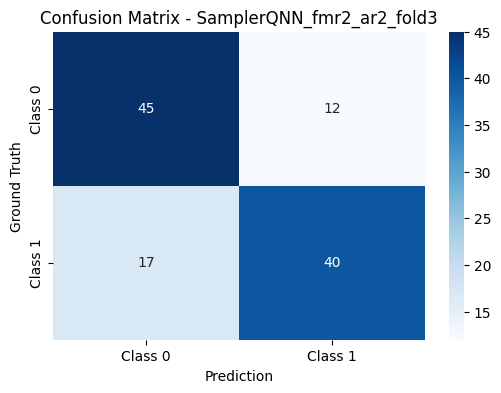

Classification report:
              precision    recall  f1-score   support

     Class 0       0.73      0.79      0.76        57
     Class 1       0.77      0.70      0.73        57

    accuracy                           0.75       114
   macro avg       0.75      0.75      0.75       114
weighted avg       0.75      0.75      0.75       114

Averaging method: macro
Metrics:
	TP: 40.0
	FP: 12.0
	FN: 17.0
	TN: 45.0
	TPR: 0.7018
	SPC: 0.7895
	PPV: 0.7692
	F1: 0.7339
	ACC: 0.7456
	NPV: 0.7258
	FPR: 0.2105
	FDR: 0.2308
	FNR: 0.2982
	MCC: 0.4931
Fold time: 514 seconds
Fold 4:


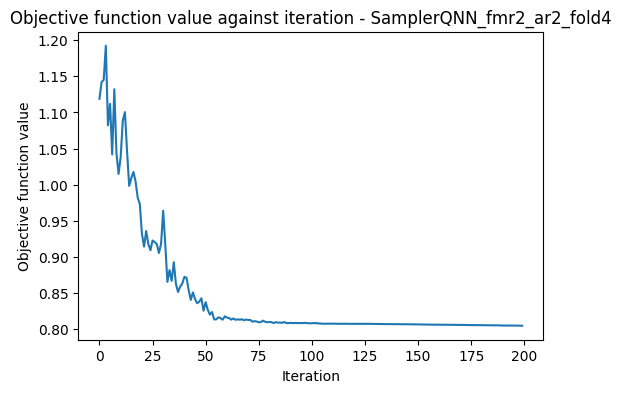

Final loss: 0.8044895691641111
Validation score: 0.6578947368421053


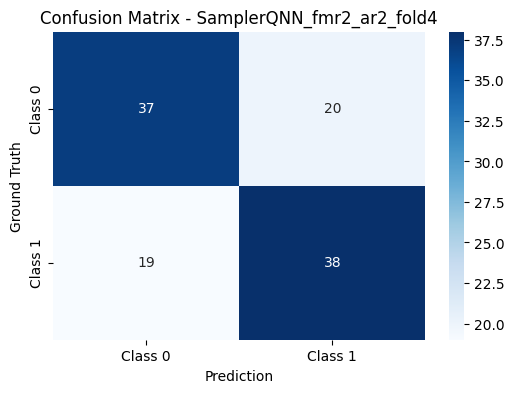

Classification report:
              precision    recall  f1-score   support

     Class 0       0.66      0.65      0.65        57
     Class 1       0.66      0.67      0.66        57

    accuracy                           0.66       114
   macro avg       0.66      0.66      0.66       114
weighted avg       0.66      0.66      0.66       114

Averaging method: macro
Metrics:
	TP: 38.0
	FP: 20.0
	FN: 19.0
	TN: 37.0
	TPR: 0.6667
	SPC: 0.6491
	PPV: 0.6552
	F1: 0.6609
	ACC: 0.6579
	NPV: 0.6607
	FPR: 0.3509
	FDR: 0.3448
	FNR: 0.3333
	MCC: 0.3158
Fold time: 526 seconds
Fold 5:


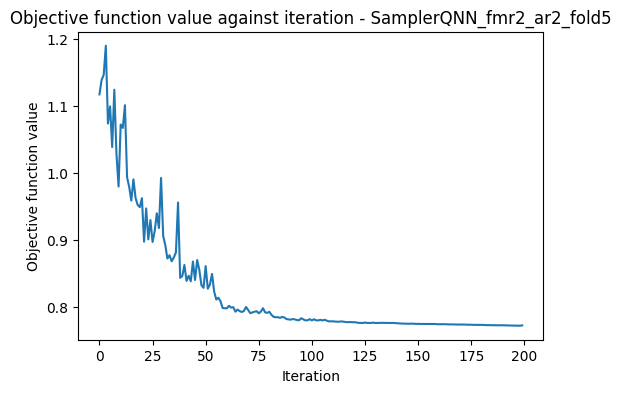

Final loss: 0.7717883771202789
Validation score: 0.7456140350877193


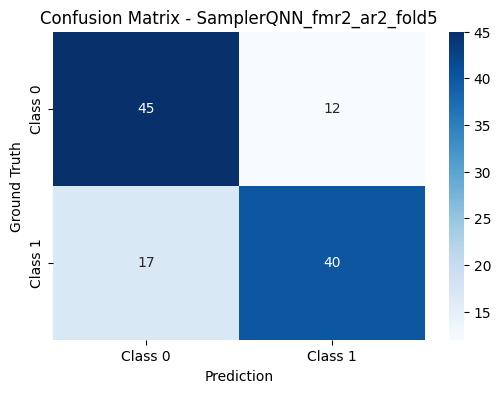

Classification report:
              precision    recall  f1-score   support

     Class 0       0.73      0.79      0.76        57
     Class 1       0.77      0.70      0.73        57

    accuracy                           0.75       114
   macro avg       0.75      0.75      0.75       114
weighted avg       0.75      0.75      0.75       114

Averaging method: macro
Metrics:
	TP: 40.0
	FP: 12.0
	FN: 17.0
	TN: 45.0
	TPR: 0.7018
	SPC: 0.7895
	PPV: 0.7692
	F1: 0.7339
	ACC: 0.7456
	NPV: 0.7258
	FPR: 0.2105
	FDR: 0.2308
	FNR: 0.2982
	MCC: 0.4931
Fold time: 528 seconds
Mean validation loss: 0.7827929083354133
Parameter combination 10/12
Model: SamplerQNN, Epochs: 200, Feature map reps: 2, Ansatz reps: 3


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


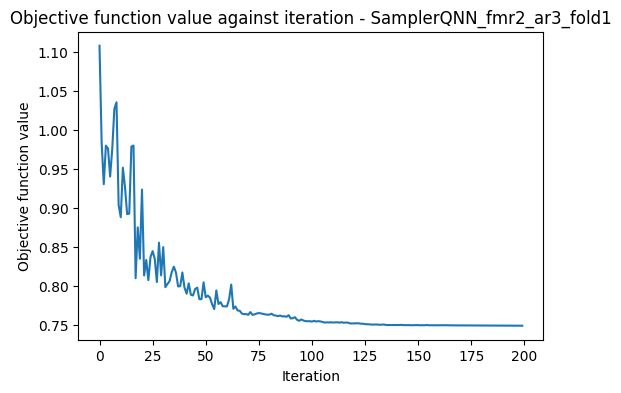

Final loss: 0.7487961537077165
Validation score: 0.7391304347826086


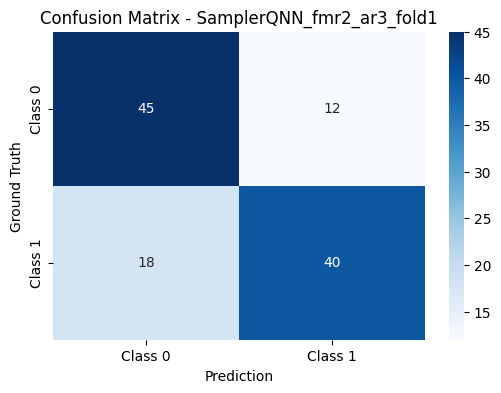

Classification report:
              precision    recall  f1-score   support

     Class 0       0.71      0.79      0.75        57
     Class 1       0.77      0.69      0.73        58

    accuracy                           0.74       115
   macro avg       0.74      0.74      0.74       115
weighted avg       0.74      0.74      0.74       115

Averaging method: macro
Metrics:
	TP: 40.0
	FP: 12.0
	FN: 18.0
	TN: 45.0
	TPR: 0.6897
	SPC: 0.7895
	PPV: 0.7692
	F1: 0.7273
	ACC: 0.7391
	NPV: 0.7143
	FPR: 0.2105
	FDR: 0.2308
	FNR: 0.3103
	MCC: 0.4813
Fold time: 583 seconds
Fold 2:


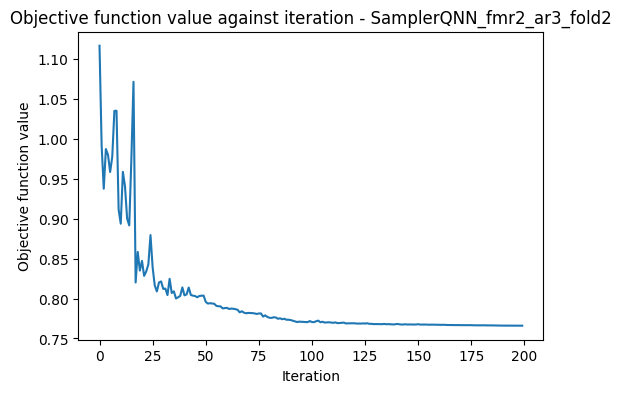

Final loss: 0.7660493408142933
Validation score: 0.7913043478260869


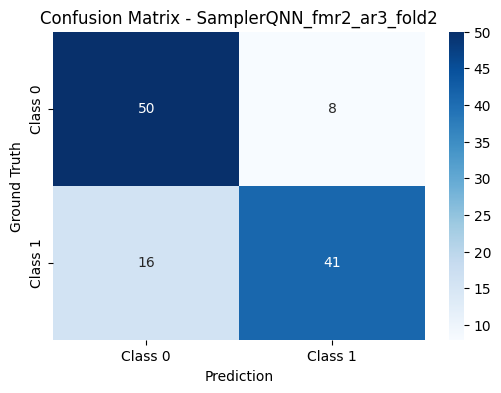

Classification report:
              precision    recall  f1-score   support

     Class 0       0.76      0.86      0.81        58
     Class 1       0.84      0.72      0.77        57

    accuracy                           0.79       115
   macro avg       0.80      0.79      0.79       115
weighted avg       0.80      0.79      0.79       115

Averaging method: macro
Metrics:
	TP: 41.0
	FP: 8.0
	FN: 16.0
	TN: 50.0
	TPR: 0.7193
	SPC: 0.8621
	PPV: 0.8367
	F1: 0.7736
	ACC: 0.7913
	NPV: 0.7576
	FPR: 0.1379
	FDR: 0.1633
	FNR: 0.2807
	MCC: 0.5878
Fold time: 578 seconds
Fold 3:


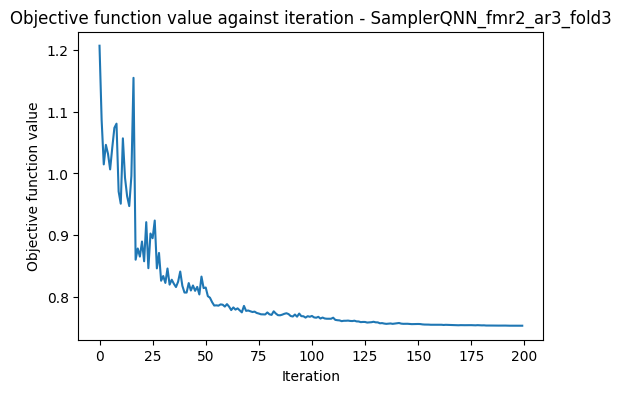

Final loss: 0.7536029875779645
Validation score: 0.7368421052631579


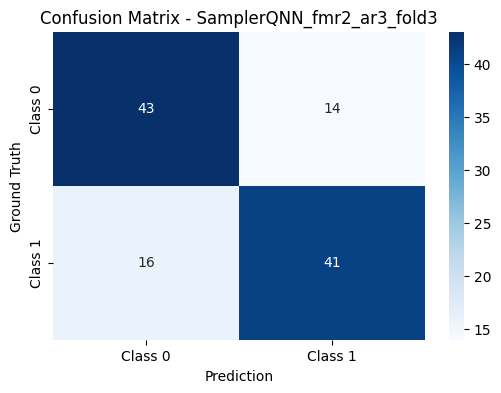

Classification report:
              precision    recall  f1-score   support

     Class 0       0.73      0.75      0.74        57
     Class 1       0.75      0.72      0.73        57

    accuracy                           0.74       114
   macro avg       0.74      0.74      0.74       114
weighted avg       0.74      0.74      0.74       114

Averaging method: macro
Metrics:
	TP: 41.0
	FP: 14.0
	FN: 16.0
	TN: 43.0
	TPR: 0.7193
	SPC: 0.7544
	PPV: 0.7455
	F1: 0.7321
	ACC: 0.7368
	NPV: 0.7288
	FPR: 0.2456
	FDR: 0.2545
	FNR: 0.2807
	MCC: 0.474
Fold time: 573 seconds
Fold 4:


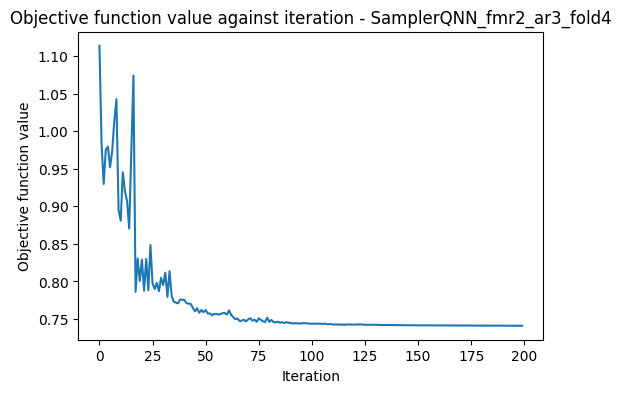

Final loss: 0.7409305898908684
Validation score: 0.6929824561403509


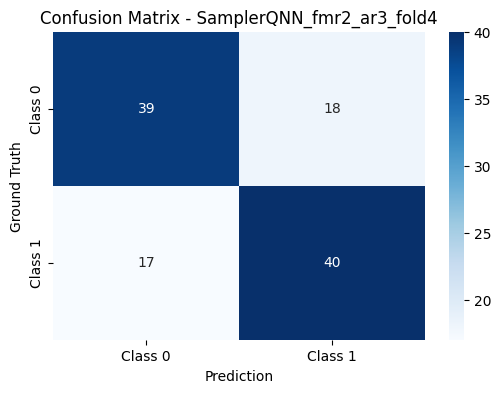

Classification report:
              precision    recall  f1-score   support

     Class 0       0.70      0.68      0.69        57
     Class 1       0.69      0.70      0.70        57

    accuracy                           0.69       114
   macro avg       0.69      0.69      0.69       114
weighted avg       0.69      0.69      0.69       114

Averaging method: macro
Metrics:
	TP: 40.0
	FP: 18.0
	FN: 17.0
	TN: 39.0
	TPR: 0.7018
	SPC: 0.6842
	PPV: 0.6897
	F1: 0.6957
	ACC: 0.693
	NPV: 0.6964
	FPR: 0.3158
	FDR: 0.3103
	FNR: 0.2982
	MCC: 0.386
Fold time: 585 seconds
Fold 5:


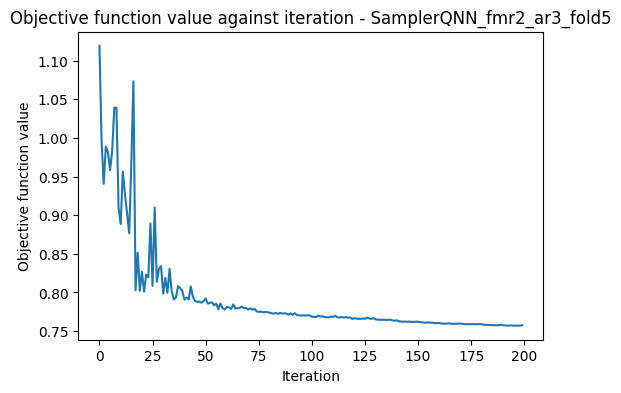

Final loss: 0.7574529456750835
Validation score: 0.7719298245614035


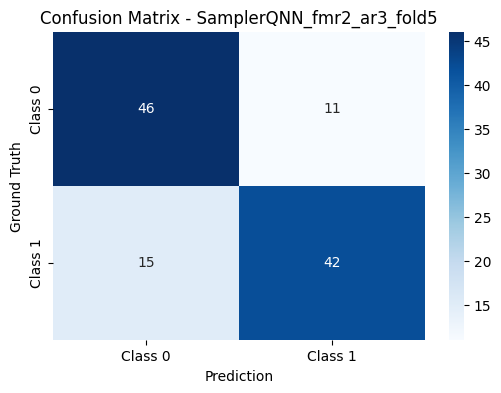

Classification report:
              precision    recall  f1-score   support

     Class 0       0.75      0.81      0.78        57
     Class 1       0.79      0.74      0.76        57

    accuracy                           0.77       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.77      0.77      0.77       114

Averaging method: macro
Metrics:
	TP: 42.0
	FP: 11.0
	FN: 15.0
	TN: 46.0
	TPR: 0.7368
	SPC: 0.807
	PPV: 0.7925
	F1: 0.7636
	ACC: 0.7719
	NPV: 0.7541
	FPR: 0.193
	FDR: 0.2075
	FNR: 0.2632
	MCC: 0.5452
Fold time: 576 seconds
Mean validation loss: 0.7533664035331852
Parameter combination 11/12
Model: SamplerQNN, Epochs: 200, Feature map reps: 3, Ansatz reps: 2


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


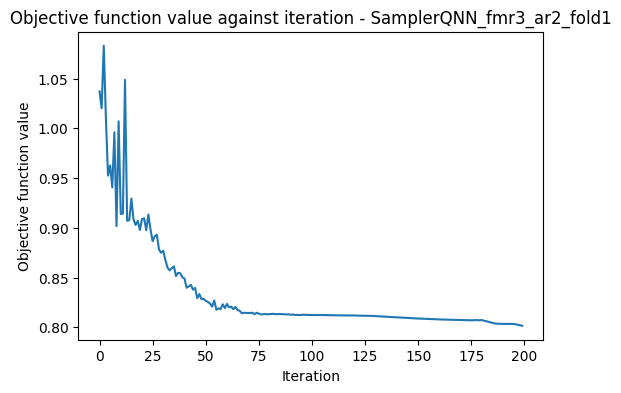

Final loss: 0.8016330916604983
Validation score: 0.7304347826086957


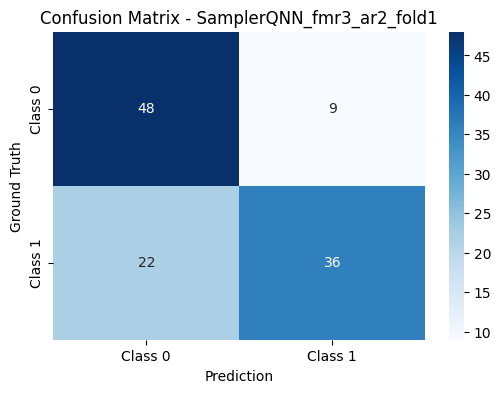

Classification report:
              precision    recall  f1-score   support

     Class 0       0.69      0.84      0.76        57
     Class 1       0.80      0.62      0.70        58

    accuracy                           0.73       115
   macro avg       0.74      0.73      0.73       115
weighted avg       0.74      0.73      0.73       115

Averaging method: macro
Metrics:
	TP: 36.0
	FP: 9.0
	FN: 22.0
	TN: 48.0
	TPR: 0.6207
	SPC: 0.8421
	PPV: 0.8
	F1: 0.699
	ACC: 0.7304
	NPV: 0.6857
	FPR: 0.1579
	FDR: 0.2
	FNR: 0.3793
	MCC: 0.4741
Fold time: 683 seconds
Fold 2:


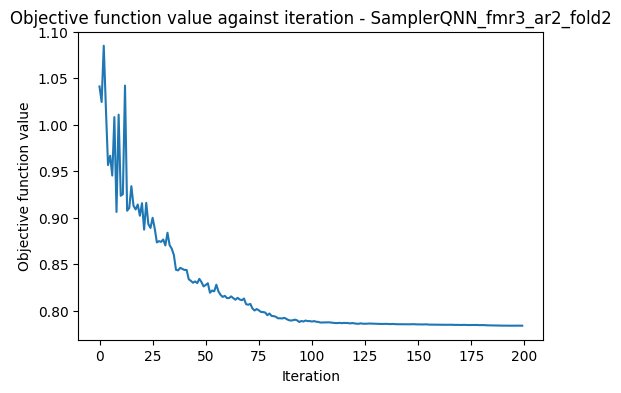

Final loss: 0.7839612324681493
Validation score: 0.7913043478260869


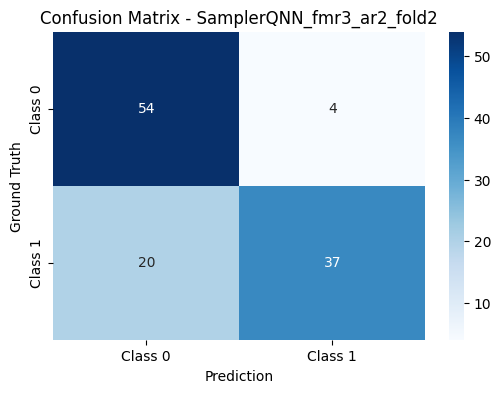

Classification report:
              precision    recall  f1-score   support

     Class 0       0.73      0.93      0.82        58
     Class 1       0.90      0.65      0.76        57

    accuracy                           0.79       115
   macro avg       0.82      0.79      0.79       115
weighted avg       0.82      0.79      0.79       115

Averaging method: macro
Metrics:
	TP: 37.0
	FP: 4.0
	FN: 20.0
	TN: 54.0
	TPR: 0.6491
	SPC: 0.931
	PPV: 0.9024
	F1: 0.7551
	ACC: 0.7913
	NPV: 0.7297
	FPR: 0.069
	FDR: 0.0976
	FNR: 0.3509
	MCC: 0.6056
Fold time: 674 seconds
Fold 3:


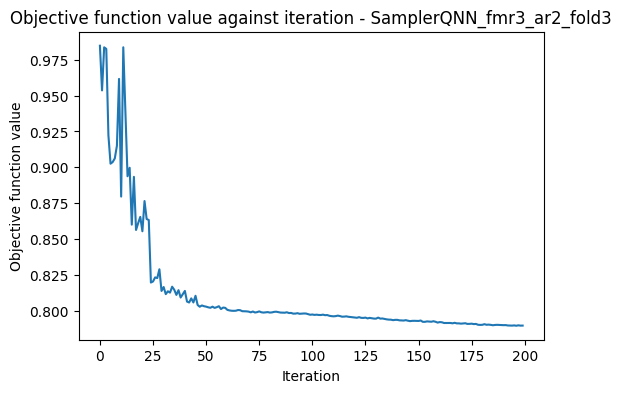

Final loss: 0.7897061208344321
Validation score: 0.7192982456140351


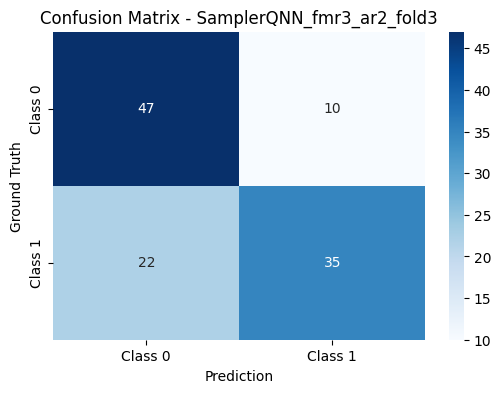

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.82      0.75        57
     Class 1       0.78      0.61      0.69        57

    accuracy                           0.72       114
   macro avg       0.73      0.72      0.72       114
weighted avg       0.73      0.72      0.72       114

Averaging method: macro
Metrics:
	TP: 35.0
	FP: 10.0
	FN: 22.0
	TN: 47.0
	TPR: 0.614
	SPC: 0.8246
	PPV: 0.7778
	F1: 0.6863
	ACC: 0.7193
	NPV: 0.6812
	FPR: 0.1754
	FDR: 0.2222
	FNR: 0.386
	MCC: 0.4487
Fold time: 674 seconds
Fold 4:


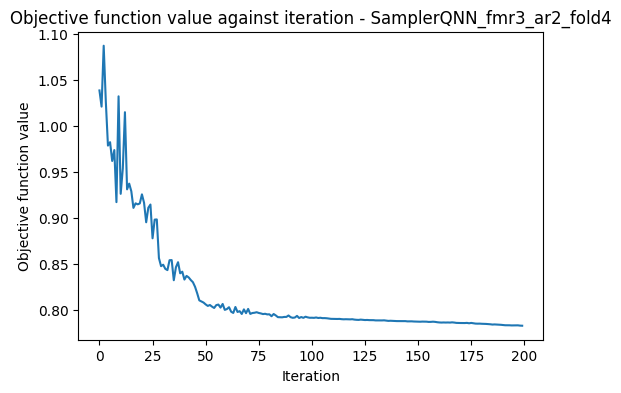

Final loss: 0.7824265384485188
Validation score: 0.6929824561403509


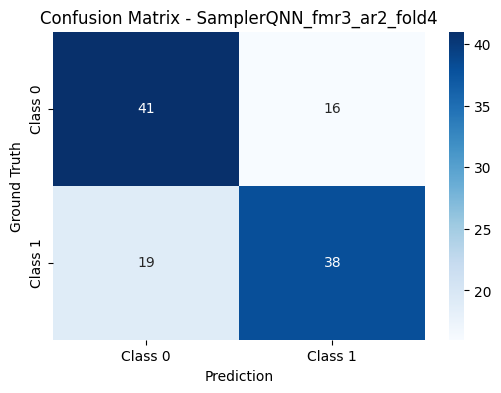

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.72      0.70        57
     Class 1       0.70      0.67      0.68        57

    accuracy                           0.69       114
   macro avg       0.69      0.69      0.69       114
weighted avg       0.69      0.69      0.69       114

Averaging method: macro
Metrics:
	TP: 38.0
	FP: 16.0
	FN: 19.0
	TN: 41.0
	TPR: 0.6667
	SPC: 0.7193
	PPV: 0.7037
	F1: 0.6847
	ACC: 0.693
	NPV: 0.6833
	FPR: 0.2807
	FDR: 0.2963
	FNR: 0.3333
	MCC: 0.3865
Fold time: 677 seconds
Fold 5:


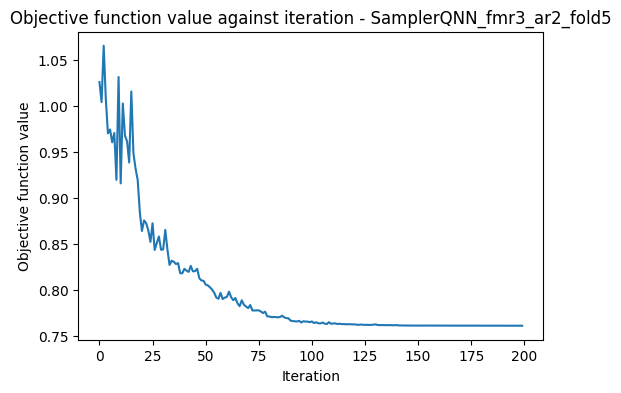

Final loss: 0.7614044407166424
Validation score: 0.7368421052631579


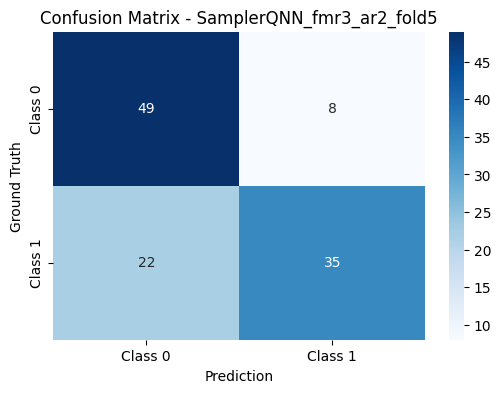

Classification report:
              precision    recall  f1-score   support

     Class 0       0.69      0.86      0.77        57
     Class 1       0.81      0.61      0.70        57

    accuracy                           0.74       114
   macro avg       0.75      0.74      0.73       114
weighted avg       0.75      0.74      0.73       114

Averaging method: macro
Metrics:
	TP: 35.0
	FP: 8.0
	FN: 22.0
	TN: 49.0
	TPR: 0.614
	SPC: 0.8596
	PPV: 0.814
	F1: 0.7
	ACC: 0.7368
	NPV: 0.6901
	FPR: 0.1404
	FDR: 0.186
	FNR: 0.386
	MCC: 0.4887
Fold time: 691 seconds
Mean validation loss: 0.7838262848256482
Parameter combination 12/12
Model: SamplerQNN, Epochs: 200, Feature map reps: 3, Ansatz reps: 3


C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Fold 1:


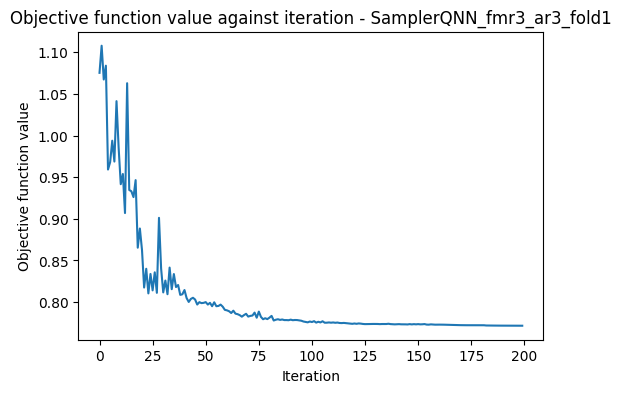

Final loss: 0.7715390278969009
Validation score: 0.7304347826086957


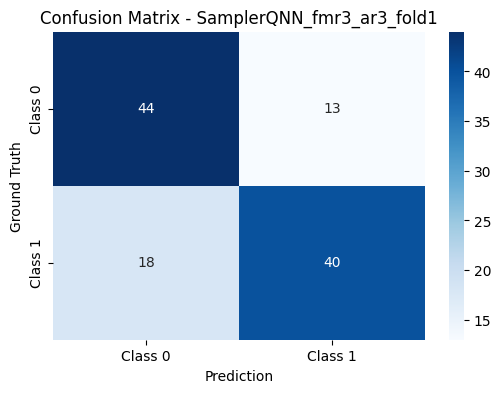

Classification report:
              precision    recall  f1-score   support

     Class 0       0.71      0.77      0.74        57
     Class 1       0.75      0.69      0.72        58

    accuracy                           0.73       115
   macro avg       0.73      0.73      0.73       115
weighted avg       0.73      0.73      0.73       115

Averaging method: macro
Metrics:
	TP: 40.0
	FP: 13.0
	FN: 18.0
	TN: 44.0
	TPR: 0.6897
	SPC: 0.7719
	PPV: 0.7547
	F1: 0.7207
	ACC: 0.7304
	NPV: 0.7097
	FPR: 0.2281
	FDR: 0.2453
	FNR: 0.3103
	MCC: 0.463
Fold time: 719 seconds
Fold 2:


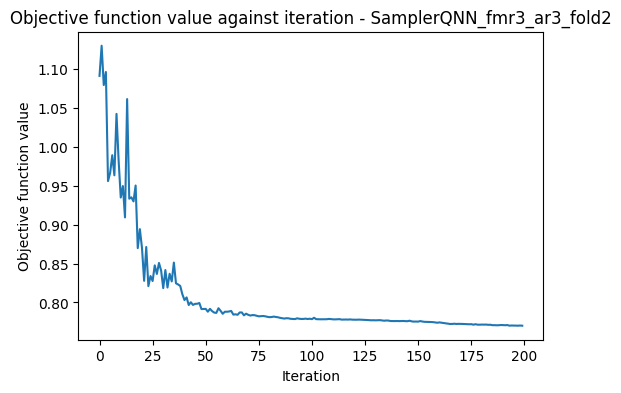

Final loss: 0.7700695617681016
Validation score: 0.7478260869565218


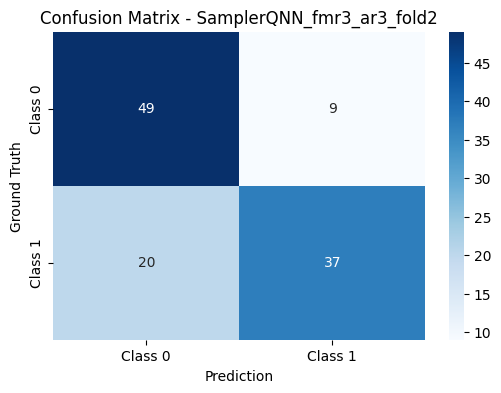

Classification report:
              precision    recall  f1-score   support

     Class 0       0.71      0.84      0.77        58
     Class 1       0.80      0.65      0.72        57

    accuracy                           0.75       115
   macro avg       0.76      0.75      0.75       115
weighted avg       0.76      0.75      0.75       115

Averaging method: macro
Metrics:
	TP: 37.0
	FP: 9.0
	FN: 20.0
	TN: 49.0
	TPR: 0.6491
	SPC: 0.8448
	PPV: 0.8043
	F1: 0.7184
	ACC: 0.7478
	NPV: 0.7101
	FPR: 0.1552
	FDR: 0.1957
	FNR: 0.3509
	MCC: 0.5041
Fold time: 726 seconds
Fold 3:


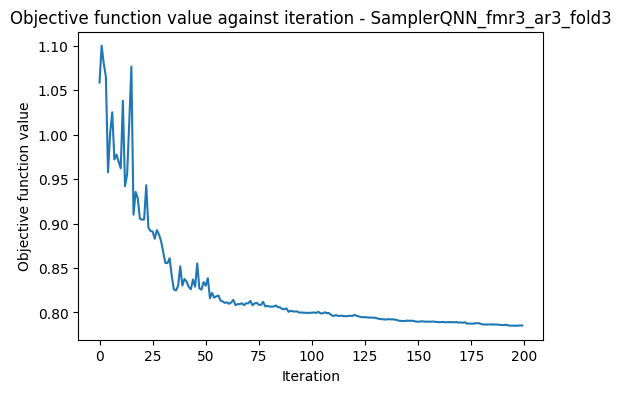

Final loss: 0.7853424781964626
Validation score: 0.6666666666666666


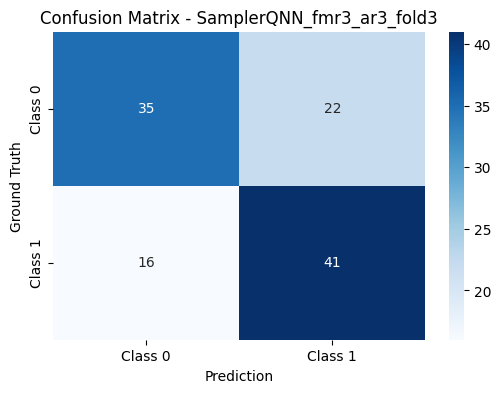

Classification report:
              precision    recall  f1-score   support

     Class 0       0.69      0.61      0.65        57
     Class 1       0.65      0.72      0.68        57

    accuracy                           0.67       114
   macro avg       0.67      0.67      0.67       114
weighted avg       0.67      0.67      0.67       114

Averaging method: macro
Metrics:
	TP: 41.0
	FP: 22.0
	FN: 16.0
	TN: 35.0
	TPR: 0.7193
	SPC: 0.614
	PPV: 0.6508
	F1: 0.6833
	ACC: 0.6667
	NPV: 0.6863
	FPR: 0.386
	FDR: 0.3492
	FNR: 0.2807
	MCC: 0.3352
Fold time: 717 seconds
Fold 4:


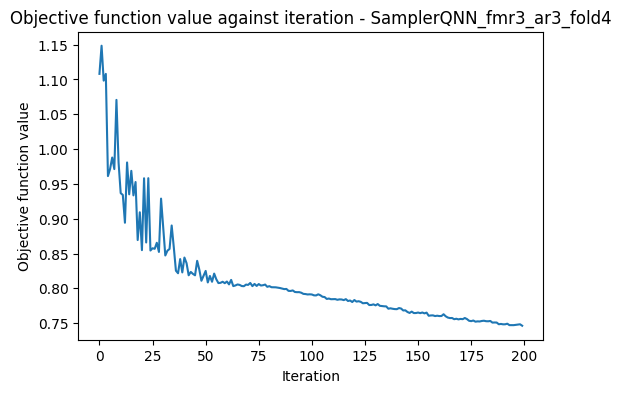

Final loss: 0.7462856887791854
Validation score: 0.6929824561403509


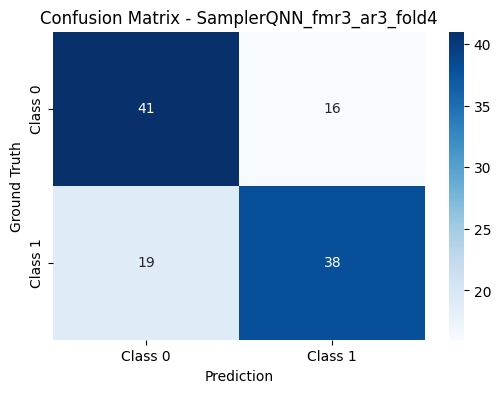

Classification report:
              precision    recall  f1-score   support

     Class 0       0.68      0.72      0.70        57
     Class 1       0.70      0.67      0.68        57

    accuracy                           0.69       114
   macro avg       0.69      0.69      0.69       114
weighted avg       0.69      0.69      0.69       114

Averaging method: macro
Metrics:
	TP: 38.0
	FP: 16.0
	FN: 19.0
	TN: 41.0
	TPR: 0.6667
	SPC: 0.7193
	PPV: 0.7037
	F1: 0.6847
	ACC: 0.693
	NPV: 0.6833
	FPR: 0.2807
	FDR: 0.2963
	FNR: 0.3333
	MCC: 0.3865
Fold time: 719 seconds
Fold 5:


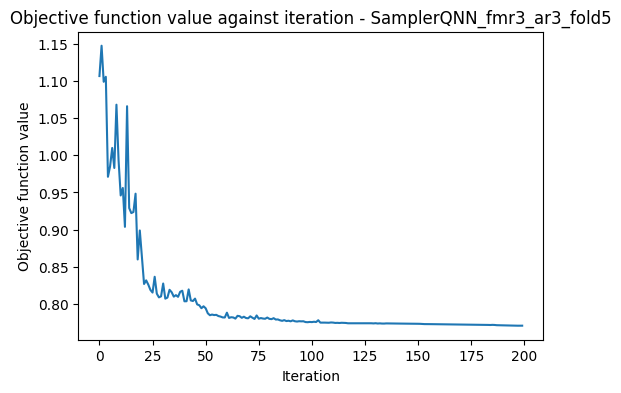

Final loss: 0.7707537675100613
Validation score: 0.7368421052631579


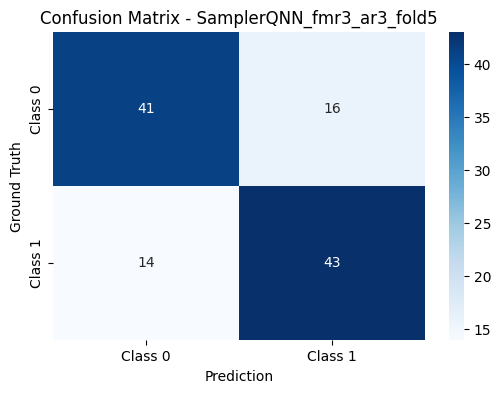

Classification report:
              precision    recall  f1-score   support

     Class 0       0.75      0.72      0.73        57
     Class 1       0.73      0.75      0.74        57

    accuracy                           0.74       114
   macro avg       0.74      0.74      0.74       114
weighted avg       0.74      0.74      0.74       114

Averaging method: macro
Metrics:
	TP: 43.0
	FP: 16.0
	FN: 14.0
	TN: 41.0
	TPR: 0.7544
	SPC: 0.7193
	PPV: 0.7288
	F1: 0.7414
	ACC: 0.7368
	NPV: 0.7455
	FPR: 0.2807
	FDR: 0.2712
	FNR: 0.2456
	MCC: 0.474
Fold time: 718 seconds
Mean validation loss: 0.7687981048301424
Total training time: 22232 seconds


In [23]:
# Initialize the StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_SEED)

# Iterate over the parameter combinations
total_start = time.time() # To store the total time taken for the entire training
mean_losses = [] # To store the mean losses for each parameter combination
metrics_columns = [] # To store the columns for the metrics
metrics_record = [] # To store the metrics for each parameter combination
for param_index, param_comb in enumerate(param_combinations):
    # Get the parameter combination
    model_name, epochs, feature_map_reps, ansatz_reps = param_comb
    create_model_fn = get_create_model_function(model_name)
    optimizer = optimizer_fn(maxiter=epochs)

    print("="*100)
    print(f"Parameter combination {param_index+1}/{len(param_combinations)}")
    print(f"Model: {model_name}, Epochs: {epochs}, Feature map reps: {feature_map_reps}, Ansatz reps: {ansatz_reps}")
    print("="*100)

    # Save the hyperparameters configuration to a file
    params_names = f'{model_name}_fmr{feature_map_reps}_ar{ansatz_reps}'
    with open(os.path.join(results_dir['hyperparameters'], f'hyperparameters_{params_names}.txt'), 'w') as f:
        f.write(f"Optimizer: {optimizer.__class__.__name__}\n")
        f.write(f"Loss function: {loss_fn}\n")
        f.write(f"Model: {model_name}\n")
        f.write(f"Epochs: {epochs}\n")
        f.write(f"Feature map reps: {feature_map_reps}\n")
        f.write(f"Ansatz reps: {ansatz_reps}\n")

    # Create the classifier model
    num_qubits = x_train.shape[1]
    classifier = create_model_fn(num_qubits, feature_map_reps, ansatz_reps, loss_fn, optimizer, callback_recorder)

    # Save the circuit diagram
    classifier_circuit = None
    if hasattr(classifier, 'circuit'):
        classifier_circuit = classifier.circuit
    else:
        classifier_circuit = classifier.neural_network.circuit
    classifier_circuit.decompose().draw(output="mpl", style="clifford", fold=20) \
        .savefig(os.path.join(results_dir['figures'], f'circuit_{params_names}.png'))

    # Iterate over the folds
    fold_losses = [] # To store the losses for each fold
    for fold_index, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
        fold_time_start = time.time() # To store the time taken for the current parameter combination

        # Display the fold number
        print(f"Fold {fold_index+1}:")

        # Define the model name
        fold_name = f"{params_names}_fold{fold_index+1}"

        # ================================================================================
        # Data Preprocessing
        # ================================================================================
        # Split the data into training and validation sets
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Normalize the data
        scaler = MinMaxScaler()
        x_train_fold = scaler.fit_transform(x_train_fold)
        x_val_fold = scaler.transform(x_val_fold)

        # ================================================================================
        # Model Training
        # ================================================================================
        # Train the model
        objective_func_vals = [] # Reset the objective function values
        classifier.fit(x_train_fold, y_train_fold)

        # Save the model
        classifier.save(os.path.join(results_dir['checkpoints'], f'{fold_name}.model'))

        # Plot the training loss curve, and save the figure
        plt.figure(figsize=(6, 4))
        plt.title(f"Objective function value against iteration - {fold_name}")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.savefig(os.path.join(results_dir['figures'], f'loss_curve_{fold_name}.png'))
        plt.show()
        plt.close()

        # Save the loss values to a file
        with open(os.path.join(results_dir['logs'], f'loss_{fold_name}.txt'), 'w') as f:
            f.write(",".join(map(str, objective_func_vals)))

        # Record the final loss value for the fold
        fold_losses.append(objective_func_vals[-1])
        print(f"Final loss: {objective_func_vals[-1]}")

        # ================================================================================
        # Model Evaluation
        # ================================================================================
        # Evaluate score on the validation data
        val_score = classifier.score(x_val_fold, y_val_fold)
        print(f"Validation score: {val_score}")

        # Calculate and plot the confusion matrix for the validation data
        y_pred_val = classifier.predict(x_val_fold)
        confusion = confusion_matrix(y_val_fold, y_pred_val)
        df_cm = pd.DataFrame(confusion, index=target_names, columns=target_names)
        plt.figure(figsize=(6, 4))
        sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Prediction")
        plt.ylabel("Ground Truth")
        plt.title(f"Confusion Matrix - {fold_name}")
        plt.savefig(os.path.join(results_dir['figures'], f'confusion_matrix_{fold_name}.png'))
        plt.show()

        # Calculate the classification report
        print("Classification report:")
        print(classification_report(y_val_fold, y_pred_val, target_names=target_names, zero_division=0))

        # Calculate the metrics
        metrics = calculate_metrics(confusion, average=average)
        metrics = {k: np.round(v, 4) for k, v in metrics.items()} # Round the values to 4 decimal places

        # Display the metrics
        print(f"Averaging method: {average}")
        print("Metrics:")
        for metric, value in metrics.items():
            print(f"\t{metric}: {value}")

        # Save the parameters and metrics to a file
        metrics_columns = ['Model Name', 'Epochs', 'Feature Map Reps', 'Ansatz Reps', 'Fold', 'Loss'] + list(metrics.keys())
        metrics_values = [model_name, epochs, feature_map_reps, ansatz_reps, fold_index+1, objective_func_vals[-1]] + list(metrics.values())
        metrics_record.append(metrics_values)

        # Calculate the time taken for the current fold
        fold_time_elapsed = time.time() - fold_time_start
        print(f"Fold time: {round(fold_time_elapsed)} seconds")

    # ================================================================================
    # Current parameter combination training is done
    # Record the mean validation score for the parameter combination
    # ================================================================================

    # Calculate the mean validation score for the parameter combination
    mean_loss = np.array(fold_losses).mean()
    mean_losses.append(mean_loss)
    print(f"Mean validation loss: {mean_loss}")

# ================================================================================
# All parameter combinations training is done
# ================================================================================
total_elapsed = time.time() - total_start
print(f"Total training time: {round(total_elapsed)} seconds")

# Save the metrics to a file
metrics_df = pd.DataFrame(metrics_record, columns=metrics_columns)
metrics_df.to_csv(os.path.join(results_dir['metrics'], 'all_metrics.csv'), index=False)

In [24]:
# Select the best parameter combination
best_param_index = np.argmin(mean_losses)
best_param_comb = param_combinations[best_param_index]
best_model_name, best_epochs, best_feature_map_reps, best_ansatz_reps = best_param_comb
best_create_model_fn = get_create_model_function(best_model_name)

print(f"Best model: {best_model_name}")
print(f"Best epochs: {best_epochs}")
print(f"Best feature map reps: {best_feature_map_reps}")
print(f"Best ansatz reps: {best_ansatz_reps}")
print(f"Best mean loss: {mean_losses[best_param_index]}")

Best model: SamplerQNN
Best epochs: 200
Best feature map reps: 2
Best ansatz reps: 3
Best mean loss: 0.7533664035331852


In [25]:
# Save the besthyperparameters configuration to a file
best_model_name = f'best_{best_model_name}_fmr{best_feature_map_reps}_ar{best_ansatz_reps}'
with open(os.path.join(results_dir['hyperparameters'], f'hyperparameters_{best_model_name}.txt'), 'w') as f:
    f.write(f"Optimizer: {optimizer.__class__.__name__}\n")
    f.write(f"Loss function: {loss_fn}\n")
    f.write(f"Model: {model_name}\n")
    f.write(f"Epochs: {epochs}\n")
    f.write(f"Feature map reps: {feature_map_reps}\n")
    f.write(f"Ansatz reps: {ansatz_reps}\n")

## Train the Model with Best Parameter Combinations

### Data Preprocessing

In [26]:
# Normalize the data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Model Training

In [27]:
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [28]:
# Create the classifier model
num_qubits = x_train.shape[1]
objective_func_vals = [] # Reset the objective function values
classifier = best_create_model_fn(num_qubits, best_feature_map_reps, best_ansatz_reps, loss_fn, optimizer, callback_graph)

# Display the circuit
classifier_circuit = None
if hasattr(classifier, 'circuit'):
    classifier_circuit = classifier.circuit
else:
    classifier_circuit = classifier.neural_network.circuit

classifier_circuit.decompose().draw(output="mpl", style="clifford", fold=20) \
    .savefig(os.path.join(results_dir['figures'], f'circuit_{best_model_name}.png'))

C:\Users\LAB502\AppData\Local\Temp\ipykernel_10444\940520646.py:20: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


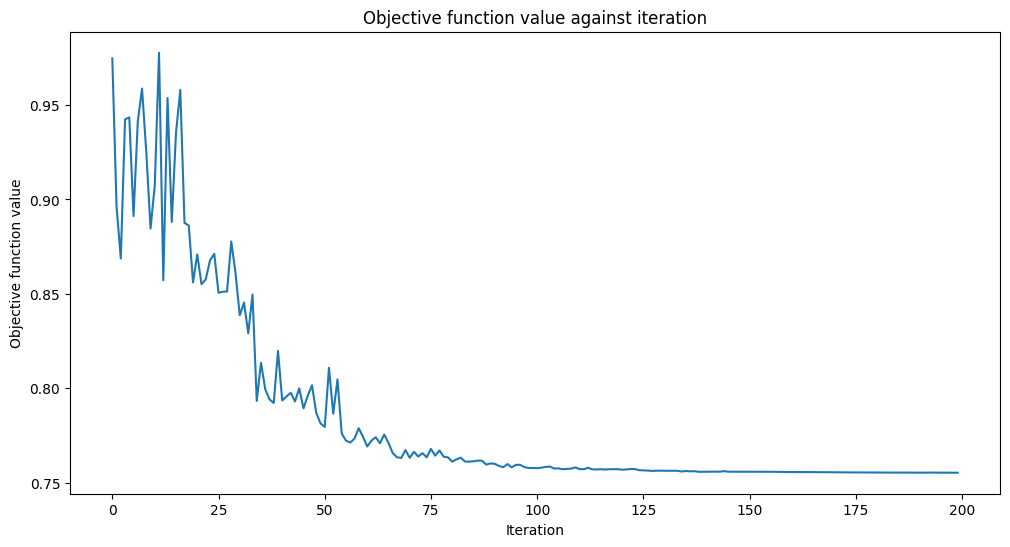

Training time: 748 seconds


In [29]:
# fit the model to the training data
start = time.time()
classifier.fit(x_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [30]:
# Save the model
classifier.save(os.path.join(results_dir['checkpoints'], f'{best_model_name}.model'))

## Performance

In [31]:
# Load the best model
best_model_path = os.path.join(results_dir['checkpoints'], f'{best_model_name}.model')
classifier = NeuralNetworkClassifier.load(best_model_path)

In [32]:
# evaluate the model on the training and testing data
train_accuracy = classifier.score(x_train, y_train)
test_accuracy = classifier.score(x_test, y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 0.756993006993007
Test accuracy: 0.6369047619047619


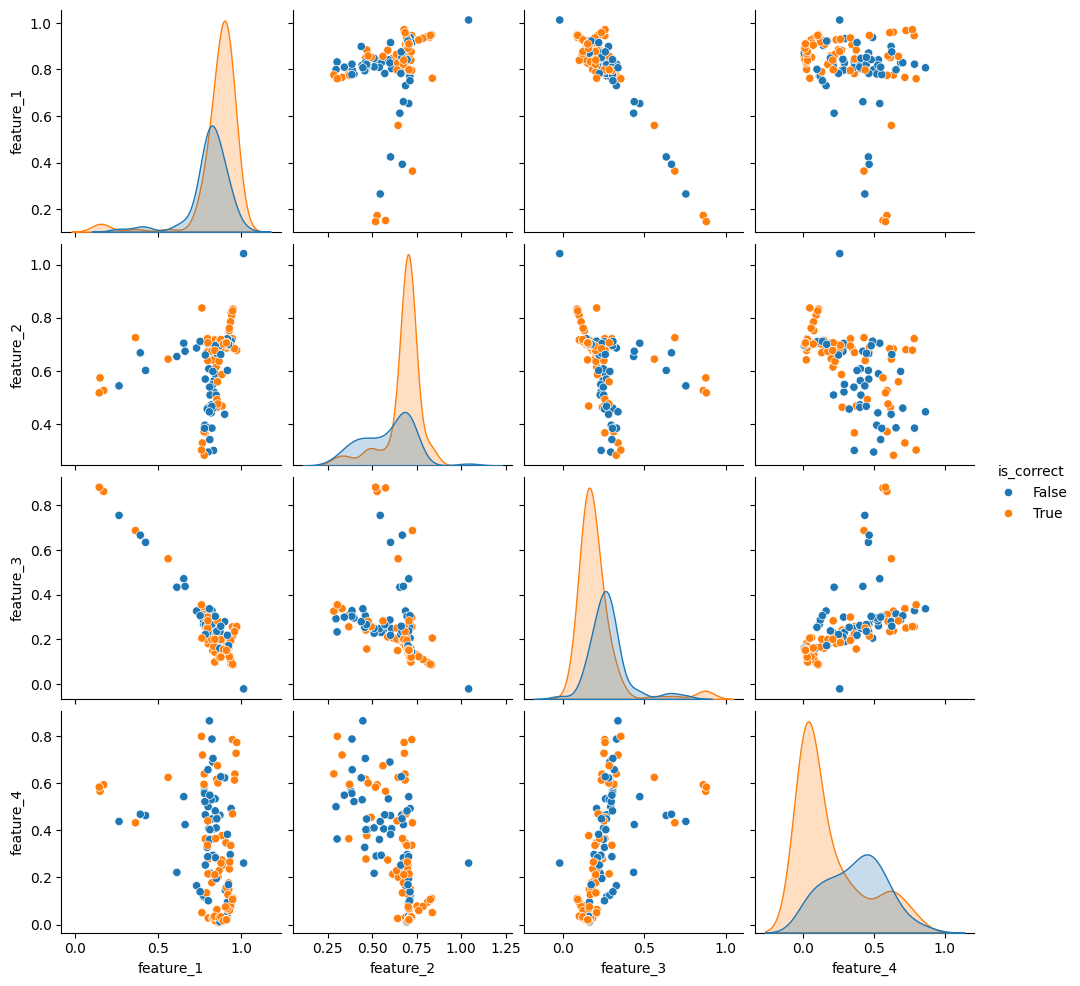

In [33]:
# predict labels
y_predict = classifier.predict(x_test)

# visualize results
valid_df = pd.DataFrame(x_test, columns=columns[:-1])
valid_df["is_correct"] = y_test == y_predict
sns.pairplot(valid_df, hue="is_correct", vars=valid_df.columns[:-1])
plt.savefig(os.path.join(results_dir['figures'], f'pairplot_{best_model_name}.png'))
plt.show()

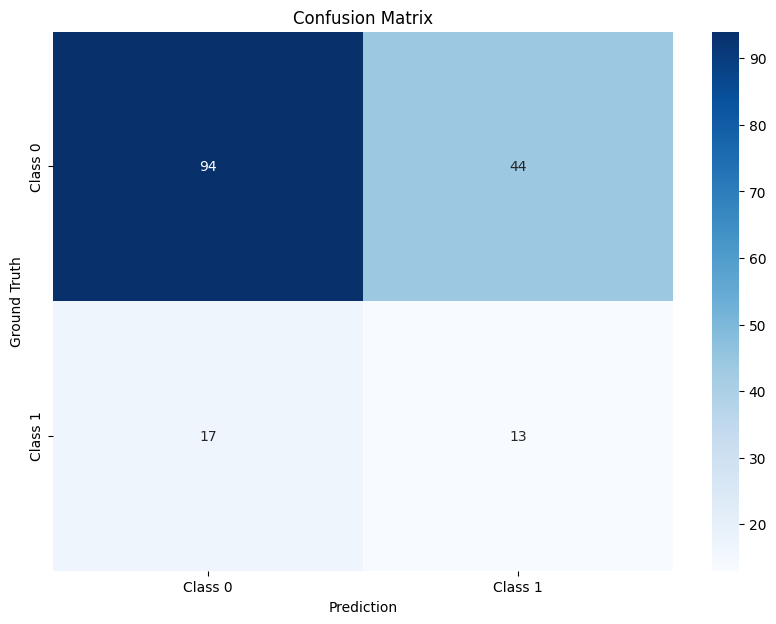

In [34]:
# compute confusion matrix
target_names = ["Class 0", "Class 1"]
confusion = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(confusion, index=target_names, columns=target_names)

# plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(results_dir['figures'], f'confusion_matrix_{best_model_name}.png'))
plt.show()

In [35]:
# Performance metrics
print("Classification report:")
print(classification_report(y_test, y_predict, target_names=target_names, zero_division=0))

Classification report:
              precision    recall  f1-score   support

     Class 0       0.85      0.68      0.76       138
     Class 1       0.23      0.43      0.30        30

    accuracy                           0.64       168
   macro avg       0.54      0.56      0.53       168
weighted avg       0.74      0.64      0.67       168



In [36]:
average = None
metrics = calculate_metrics(confusion, average=average)
metrics = {k: np.round(v, 4) for k, v in metrics.items()} # Round the values to 4 decimal places

print(f"Averaging method: {average}")
metrics_df = pd.DataFrame(metrics, index=target_names)
print(metrics_df.T) # transpose

Averaging method: None
     Class 0  Class 1
TP   13.0000  13.0000
FP   44.0000  44.0000
FN   17.0000  17.0000
TN   94.0000  94.0000
TPR   0.4333   0.4333
SPC   0.6812   0.6812
PPV   0.2281   0.2281
F1    0.2989   0.2989
ACC   0.6369   0.6369
NPV   0.8468   0.8468
FPR   0.3188   0.3188
FDR   0.7719   0.7719
FNR   0.5667   0.5667
MCC   0.0926   0.0926


In [37]:
average = 'macro'
metrics = calculate_metrics(confusion, average=average)
metrics = {k: np.round(v, 4) for k, v in metrics.items()} # Round the values to 4 decimal places

# Display the performance metrics
print(f"Averaging method: {average}")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Averaging method: macro
TP: 13.0000
FP: 44.0000
FN: 17.0000
TN: 94.0000
TPR: 0.4333
SPC: 0.6812
PPV: 0.2281
F1: 0.2989
ACC: 0.6369
NPV: 0.8468
FPR: 0.3188
FDR: 0.7719
FNR: 0.5667
MCC: 0.0926


## Save Metrics to CSV

In [ ]:
# Save the parameters and metrics to a CSV file
columns = ['Model Name', 'Epochs', 'Feature Map Reps', 'Ansatz Reps'] + list(metrics.keys())
data = [model_name, epochs, best_feature_map_reps, best_ansatz_reps] + list(metrics.values())
metrics_df = pd.DataFrame([data], columns=columns)
metrics_df.to_csv(os.path.join(results_dir['metrics'], f'metrics_{model_name}.csv'), index=False)
print(metrics_df)

   Model Name  Epochs  Feature Map Reps  Ansatz Reps    TP    FP    FN    TN  \
0  SamplerQNN     200                 2            3  13.0  44.0  17.0  94.0   

      TPR     SPC     PPV      F1     ACC     NPV     FPR     FDR     FNR  \
0  0.4333  0.6812  0.2281  0.2989  0.6369  0.8468  0.3188  0.7719  0.5667   

      MCC  
0  0.0926  
